In [2]:
#!pip install torch==1.10.0+cu111 torchvision==0.11.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html
!pip install deeplake
!pip install --upgrade numpy
! pip install timm
! pip install einops
! pip install pycocotools

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Using cached deeplake-3.1.3.tar.gz (397 kB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 36.6 MB/s eta 0:00:0000:0100:01
  Created wheel for deeplake: filename=deeplake-3.1.3-py3-none-any.whl size=481644 sha256=2b322d7a0580908da75953927d42aaeb89768a0644cb31ba76a6f36094ecb5fc
  Stored in directory: /home/ec2-user/.cache/pip/wheels/d1/af/f6/f03661a46f5e33fe3d4beb7210709c07873449f7d7bb8d0449
Successfully built deeplake
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 31.2 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 22.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.3/24.3 MB 18.4 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 1.5.1
    Uninstalling torch-1.5.1:
      Successfully uninstalled torch-1.5.1
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.6.1
    Uninstalling torchvision-0.6.1:
      Successfully uninstalled torchvision-0.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torcheia 1.0.0 requires torch==1.5.1, but you have torch 1.13.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 1.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.am

In [2]:
#!pip install --upgrade torch torchvision

In [3]:
#! pip install torchvision==0.14.0

In [4]:
"""Implementation of New Instance segmentation network motivated by SOLO but much simpler. The idea is that the task
for veg detetion is not that diffucult can we build a network which is much simpler and atleast 10x faster than what is out there
"""

'Implementation of New Instance segmentation network motivated by SOLO but much simpler. The idea is that the task\nfor veg detetion is not that diffucult can we build a network which is much simpler and atleast 10x faster than what is out there\n'

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import deeplake as hub
import numpy.random as random
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

In [5]:
import torch

In [6]:
import torchvision

In [7]:
torch.__version__,torchvision.__version__

('1.13.0+cu117', '0.14.0+cu117')

In [8]:
from torchvision.ops import sigmoid_focal_loss
from torchvision.ops import generalized_box_iou_loss

In [9]:
src="hub://aismail2/cucumber_OD"
#src="hub://aismail2/pepper_Scalecam_OD"

In [11]:
ds = hub.load(src)

hub://aismail2/cucumber_OD loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/aismail2/cucumber_OD


In [12]:
len(ds)

295

(1536, 2048, 2)


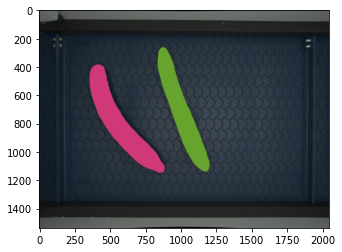

In [13]:
i=220
image=ds.images[i].numpy()
masks=ds.masks[i].numpy().astype(np.uint8)*255
print(masks.shape)
all_cnts=[]
for j in range(masks.shape[-1]):
    randcolor=[np.random.randint(0,255) for _ in range(3)]
    image[np.where(masks[...,j]!=0)]=randcolor
plt.imshow(image)

In [14]:
## For solo we need to find the centroid of objects

In [18]:
"""Fixed Mask if centroid is not in the middle go to left to find one valid point"""
def fixed_points(x,y,mask):
    h,w=mask.shape
    while x<w and mask[y][x]==0:
        x+=1
    return (y,x)

In [19]:
def get_quantized_center(x,y,mask,dst_size=24,p_sofar=None):
    h,w=mask.shape
    cy=y*(dst_size/h)
    cx=x*(dst_size/w) 
    # Quantized centers
    cyq=int(cy)
    cxq=int(cx)
    # Offsets of centers
    offy=cy-cyq
    offx=cx-cxq
    if (cyq,cxq) in p_sofar:
        assert False
    p_sofar.add((cyq,cxq))
    return cyq,cxq,offy,offx,p_sofar

In [20]:
def find_center(mask):
    (ys,xs)=np.nonzero(mask)
    points=list(zip(xs,ys))
    h,w=mask.shape
    assert max(ys)<h and max(xs)<w
    #horizontal cucumber
    midx=None
    midy=None
    if abs(max(ys)-min(ys))<abs(max(xs)-min(xs)):
        xs=sorted(xs)
        midx=xs[len(xs)//2]
        yrel=[y for  x,y in points if x==midx]
        yrel=sorted(yrel)
        midy=yrel[len(yrel)//2]
    else:
        ys=sorted(ys)
        midy=ys[len(ys)//2]
        xrel=[x for  x,y in points if y==midy]
        xrel=sorted(xrel)
        midx=xrel[len(xrel)//2]
    return (midy,midx)    

In [21]:
def find_center_cv(mask):
    contours, hierarchy = cv2.findContours(mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    h,w=mask.shape
    c = max(contours, key = cv2.contourArea)
    M = cv2.moments(c)
    #calculate x,y coordinate of center
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    return (cY,cX)

In [22]:
## Pytorch Dataloader

In [23]:
from torchvision.transforms import Compose, Resize,Normalize,Lambda
import torch

In [24]:
mean=torch.tensor([0.4850, 0.4560, 0.4060])
std=torch.tensor([0.2290, 0.2240, 0.2250])

In [25]:
transform = Compose([
            Lambda(lambda t: t.permute(2, 0, 1)), # HWC to CHW
            Normalize(mean, std)
])

In [26]:
postprocess = Compose([
     Lambda(lambda t: (t.cpu() * std.reshape(3,1,1))+mean.reshape(3,1,1)),
     Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     Lambda(lambda t: t * 255.),
     Lambda(lambda t: t.cpu().numpy().astype(np.uint8)),
])

In [27]:
import torch.utils.data as data
import torch
class DataLoader(data.Dataset):
    def __init__(self,ds,img_sz=512,grid_sz=64,seg_sz=64,data=None):
        super(DataLoader, self).__init__()
        self.img_sz=img_sz
        self.grid_sz=grid_sz
        self.seg_sz=seg_sz
        self.imgs=[]
        self.label_pts=[]
        self.label_off=[]
        self.label_masks=[]
        self.label_boxes=[]
        self.getData(ds)
        
    def getData(self,ds):
        for i,d in tqdm(enumerate(ds)):
            image=d.images.numpy()
            image=cv2.resize(image,(self.img_sz,self.img_sz))
            masks=d.masks.numpy().astype(np.uint8)*255
            img_cs=set(())
            mod_masks=[]
            mod_boxes=[]
            mod_centers=[]
            mod_offsets=[]
            grid=np.zeros((self.grid_sz,self.grid_sz),dtype=np.uint8)
            for j in range(masks.shape[-1]):
                mask=masks[...,j]
                mask=cv2.resize(mask,(self.img_sz,self.img_sz),cv2.INTER_NEAREST)
                cY,cX=find_center(mask)
                if not mask[cY][cX]:
                    cY,cX=fixed_points(cX,cY,mask)
                cY,cX,offy,offx,img_cs=get_quantized_center(cX,cY,mask,dst_size=self.grid_sz,p_sofar=img_cs)
                mod_centers.append([cY,cX])
                mod_offsets.append([offy,offx])
                nzeros=np.nonzero(mask)
                ys=nzeros[0]
                xs=nzeros[1]
                ymin=min(ys)
                ymax=max(ys)
                xmin=min(xs)
                xmax=max(xs)
                croped_mask = mask[ymin : ymax , xmin: xmax]
                ## resize masks to eventual size of masks to be predicted
                croped_mask=cv2.resize(croped_mask,(self.seg_sz,self.seg_sz),cv2.INTER_NEAREST)
                mod_masks.append(croped_mask)            
                mod_boxes.append([xmin,ymin,xmax,ymax])
                # Considering only one calss can add dict with value corresponding to class for multiclass
            self.label_pts.append(mod_centers)
            self.label_off.append(mod_offsets)
            self.imgs.append(image)
            self.label_masks.append(mod_masks)
            self.label_boxes.append(mod_boxes)
        
    def __getitem__(self, index):
        
        tgt_img = self.imgs[index]
        pts = self.label_pts[index]
        offs= self.label_off[index]
        masks = self.label_masks[index]
        boxes = self.label_boxes[index]
        tgt_masks=np.zeros((self.grid_sz*self.grid_sz,self.seg_sz,self.seg_sz),dtype=np.uint8)
        tgt_label=np.zeros((self.grid_sz,self.grid_sz),dtype=np.uint8)
        tgt_boxes=np.zeros((self.grid_sz,self.grid_sz,4),dtype=np.float32)
        for i,pt in enumerate(pts):
            #first point is y second is x
            tgt_label[pt[0]][pt[1]]=1
            idx=pt[0]*self.grid_sz+pt[1]
            tgt_masks[idx]= masks[i]//255
            for j in range(4):
                tgt_boxes[pt[0]][pt[1]][j]= boxes[i][j]
        data={}
        data["img"]=transform((torch.from_numpy(tgt_img).float()/255))
        data["pts"]=torch.tensor(pts)
        data["offs"]=torch.tensor(offs).float()
        data["center"]=torch.from_numpy(tgt_label).float()
        data["bboxs"]=torch.from_numpy(tgt_boxes).float()
        data["msks"]=torch.from_numpy(tgt_masks).float()   
        return data
    
    def __len__(self):
        return len(ds)

In [28]:
data=DataLoader(ds=ds)

295it [00:29,  9.91it/s]


In [29]:
assert len(data.label_pts)==len(data.imgs)

In [30]:
#data.label_pts[251]

In [31]:
d=data[219]
img=d["img"]
pts=d["pts"]
offs=d["offs"]
boxes=d["bboxs"]
lbl=d["center"]
msks=d["msks"]
img.shape,pts.shape,offs.shape,lbl.shape,boxes.shape,msks.shape

(torch.Size([3, 512, 512]),
 torch.Size([3, 2]),
 torch.Size([3, 2]),
 torch.Size([64, 64]),
 torch.Size([64, 64, 4]),
 torch.Size([4096, 64, 64]))

In [32]:
img.min(),img.max(), lbl.min(),lbl.max(),pts.max(),pts.min(),offs.min(),offs.max(),boxes.min(),boxes.max()

(tensor(-2.1179),
 tensor(1.4307),
 tensor(0.),
 tensor(1.),
 tensor(46),
 tensor(17),
 tensor(0.),
 tensor(0.6250),
 tensor(0.),
 tensor(423.))

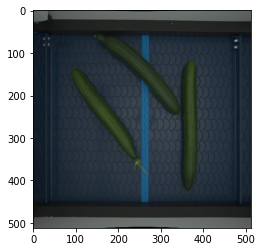

In [33]:
vis_img=postprocess(img)
plt.imshow(vis_img)

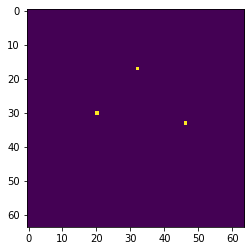

In [34]:
plt.imshow(lbl.numpy().astype(np.uint8))

In [35]:
for idx in range(len(pts)):
    box=boxes[pts[idx][0],pts[idx][1]]
    cv2.rectangle(vis_img, (box[0],box[1]), (box[2],box[3]), (255,0,0), 5)

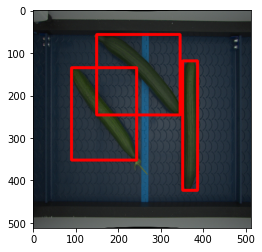

In [36]:
plt.imshow(vis_img)

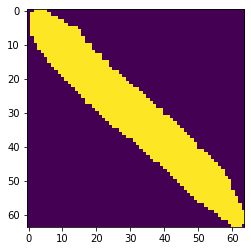

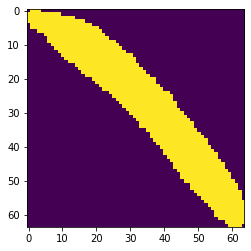

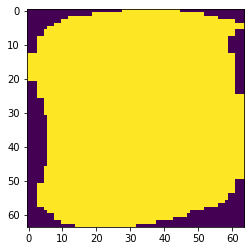

In [37]:
for idx in range(len(pts)):
    msk=msks[pts[idx][0]*64+pts[idx][1]]
    msk=msk.numpy()
    plt.figure(idx+1)
    plt.imshow(msk)

In [36]:
### Build effective but simple model

In [37]:
## Load dataloader

In [38]:
BATCH_SIZE=16

In [39]:
def collate_batch(batch):
    inputs={}
    for k in batch[0].keys():
        inps=[item[k] for item in batch]
        if k!="pts" and k!="offs":
            inps=torch.stack(inps)
        inputs[k]=inps
    return inputs

In [40]:
from torch.utils.data import DataLoader
data_loader = DataLoader(dataset=data, batch_size=BATCH_SIZE,num_workers=4,collate_fn=collate_batch,shuffle=True)

In [41]:
for batch in data_loader:
    print(batch.keys())
    print(batch["img"].shape)
    print(batch["center"].shape)
    print(batch["bboxs"].shape)
    print(batch["msks"].shape)
    gt_center=batch["pts"]
    print(gt_center)
    #print(batch[0].shape,len(batch[1]),len(batch[2]),batch[3].shape,batch[4].shape,batch[5].shape)
    break

dict_keys(['img', 'pts', 'offs', 'center', 'bboxs', 'msks'])
torch.Size([16, 3, 512, 512])
torch.Size([16, 64, 64])
torch.Size([16, 64, 64, 4])
torch.Size([16, 4096, 64, 64])
[tensor([[33, 41],
        [31, 52]]), tensor([[33, 41],
        [34, 53]]), tensor([[33, 19],
        [31, 29],
        [33, 36],
        [29, 47]]), tensor([[27, 23]]), tensor([[31, 33]]), tensor([[33, 44]]), tensor([[11, 32],
        [28, 33],
        [47, 35]]), tensor([[30, 25],
        [33, 34],
        [32, 42]]), tensor([[29, 24],
        [38, 30],
        [32, 33],
        [31, 42],
        [42, 45],
        [33, 50],
        [24, 53]]), tensor([[37, 28],
        [25, 38]]), tensor([[30, 25],
        [31, 17]]), tensor([[27, 18]]), tensor([[31, 50]]), tensor([[34, 14]]), tensor([[32, 19]]), tensor([[34, 46]])]


In [38]:
import timm
#timm.list_models('resnet*', pretrained=True)

In [39]:
from einops import  repeat

In [40]:
def min_max_norm(x,a,b):
    min_x=x.min()
    max_x=x.max()
    return a+((x-min_x)*(b-a)/(max_x-min_x))

In [41]:
import torch.nn.functional as F
import torch.nn as nn

In [42]:
def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

In [43]:
def decode_boxes(cx,cy,pred_szs,pred_offs,stride):
    cx = (cx+pred_offs[:,0]) * stride 
    cy = (cy+pred_offs[:,1]) * stride
    pred_szs*=stride
    x_min = cx - (pred_szs[:,0])
    y_min = cy - (pred_szs[:,1])
    x_max = cx + (pred_szs[:,2])
    y_max = cy + (pred_szs[:,3])
    result= torch.stack([x_min, y_min, x_max, y_max], axis=-1)
    return result.float()

In [44]:
def process_preds(preds,grid_sz=64,cat_th=0.4): 
    pred_cats=preds["center"].cpu()
    pred_cats=pred_cats.squeeze(0).sigmoid()
    pred_cats[pred_cats<cat_th]=0   
    nzidx=torch.nonzero(pred_cats)
    bidx=nzidx[:,0]    
    idx=nzidx[:,1]
    jdx=nzidx[:,2]
    mskidx=nzidx[:,1]*grid_sz+nzidx[:,2]
    ## Select boxes
    pred_boxes=preds["boxes"].cpu()
    pred_offs=preds["offs"].cpu()
    pred_boxes=pred_boxes[bidx,idx,jdx,:].detach().numpy()
    pred_offs=pred_offs[bidx,idx,jdx,:].detach().numpy()
    pred_boxes=decode_boxes(jdx,idx,pred_boxes,pred_offs,8.0)
    scores=pred_cats[bidx,idx,jdx]
    labels=torch.ones_like(scores).to(torch.long) 
    preds={"centers":pred_cats,"boxes":pred_boxes,"scores":scores,"labels":labels}
    return preds

In [45]:
#boxes.exp()

In [46]:
def prepare_data(gts,preds,stride=8,device="cpu"):    
    gt_pts=gts["pts"]
    gt_offs=gts["offs"]
    gt_boxes=gts["bboxs"]
    gt_msks=gts["msks"]
    gt_centers=gts["center"]
    
    pred_offs=preds["offs"]
    pred_szs=preds["boxes"]
    
    fil_gt_box=[]
    fil_tgt_box=[] # For keeping the processed distance from centers
    fil_gt_msks=[]
    fil_gt_cts=[]
    fil_gt_offs=[]
    
    fil_pred_szs=[]
    fil_pred_offs=[]
    
    for i,pts in enumerate(gt_pts):
        fil_gt_box.append(gt_boxes[i,pts[:,0],pts[:,1]])
        fil_pred_szs.append(pred_szs[i,pts[:,0],pts[:,1]])
        
        mskidx=pts[:,0]*64+pts[:,1]      
        fil_gt_msks.append(gt_msks[i,mskidx])
        #fil_pred_msks.append(pred_msks[i,mskidx])
        
        # convert y,x to x,y
        fil_gt_offs.append(torch.fliplr(gt_offs[i]))
        fil_pred_offs.append(pred_offs[i,pts[:,0],pts[:,1]])
        
        ## convert y,x to x,y for box adjustments 
        fil_gt_cts.append(torch.fliplr(pts))
        
        pboxesmin=(fil_gt_cts[-1]+fil_gt_offs[-1])-(fil_gt_box[-1][...,:2]/stride)
        pboxesmax=(fil_gt_box[-1][...,2:]/stride)-(fil_gt_cts[-1]+fil_gt_offs[-1])
        
        pboxes=torch.hstack((pboxesmin,pboxesmax))
        #if torch.any(pboxes<0):
        #    raise("Negative boxes!!")
        fil_tgt_box.append(pboxes)

    #tgt_box=torch.concatenate(fil_gt_box).to(device)
    tgt_box=torch.concatenate(fil_tgt_box).to(device)
    tgt_msks=torch.concatenate(fil_gt_msks).to(device)
    
    pred_szs=torch.concatenate(fil_pred_szs).to(device)
    pred_offs=torch.concatenate(fil_pred_offs).to(device)
    
    #fil_gt_cts=torch.concatenate(fil_gt_cts).cuda()
    tgt_offs=torch.concatenate(fil_gt_offs).to(device)
    
    return pred_szs,tgt_box,pred_offs,tgt_offs,tgt_msks,fil_gt_box

In [47]:
def calc_loss(gts,preds,device="cuda"):
    #n_positive= torch.sum(gt_cats>0) 
    #print(n_positive)
    
    pred_szs,tgt_szs,pred_offs,tgt_offs,tgt_msks,boxlist=prepare_data(gts,preds,stride=8.0,device=device)
    #pred_offs,tgt_offs=get_processed_boxes(centers,offsets,gt_boxes,pred_boxes,pred_offsets)
    
    box_loss1=F.l1_loss(pred_szs,tgt_szs,reduction="mean")
    box_loss2=F.mse_loss(pred_szs,tgt_szs,reduction="mean")
    box_loss=box_loss1+box_loss2
    
    off_loss=F.l1_loss(pred_offs,tgt_offs,reduction="mean")
    
    gt_cats=gts["center"]
    pred_cats=preds["center"]
    ## Centerness Focal Loss
    gt_cats=gt_cats.unsqueeze(1)
    cat_loss=sigmoid_focal_loss(pred_cats,gt_cats,reduction="mean")
    cat_loss=cat_loss

    return {"cat_loss":cat_loss,"box_loss":box_loss,"off_loss":off_loss},tgt_msks,boxlist

In [48]:
from torchvision.ops import roi_align

In [49]:
class BinaryDiceLoss(nn.Module):
    """Dice loss of binary class
    Args:
        smooth: A float number to smooth loss, and avoid NaN error, default: 1
        p: Denominator value: \sum{x^p} + \sum{y^p}, default: 2
        predict: A tensor of shape [N, *]
        target: A tensor of shape same with predict
        reduction: Reduction method to apply, return mean over batch if 'mean',
            return sum if 'sum', return a tensor of shape [N,] if 'none'
    Returns:
        Loss tensor according to arg reduction
    Raise:
        Exception if unexpected reduction
    """
    def __init__(self, smooth=1, p=2, reduction='mean'):
        super(BinaryDiceLoss, self).__init__()
        self.smooth = smooth
        self.p = p
        self.reduction = reduction

    def forward(self, predict, target):
        assert predict.shape[0] == target.shape[0], "predict & target batch size don't match"
        predict = predict.contiguous().view(predict.shape[0], -1)
        target = target.contiguous().view(target.shape[0], -1)

        num = torch.sum(torch.mul(predict, target), dim=1) + self.smooth
        den = torch.sum(predict.pow(self.p) + target.pow(self.p), dim=1) + self.smooth

        loss = 1 - num / den

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        elif self.reduction == 'none':
            return loss
        else:
            raise Exception('Unexpected reduction {}'.format(self.reduction))

In [50]:
def posEncoding(x):
    b=x.shape[0]
    xpos=torch.arange(x.shape[-1]).to(x)
    xpos=repeat(xpos, 'i -> i newaxis', newaxis=x.shape[-1])
    xpos=min_max_norm(xpos,-1,1).reshape(1,x.shape[-1],x.shape[-1])

    ypos=torch.arange(x.shape[-2]).to(x)
    ypos=repeat(ypos, 'i -> newaxis i', newaxis=x.shape[-2])
    ypos=min_max_norm(ypos,-1,1).reshape(1,x.shape[-2],x.shape[-2])

    xpos=repeat(xpos,'i j k -> b i j k',b=b)
    ypos=repeat(ypos,'i j k -> b i j k',b=b)
    ## Append 
    x=torch.cat([x,xpos,ypos],axis=1)
    return x

In [51]:
class FCOS(nn.Module):
    def __init__(self,grid_sz=32) -> None:
        super(FCOS, self).__init__()
        self.grid_sz=grid_sz
        self.backbone=timm.create_model('resnet18', pretrained=True, in_chans=3,num_classes=0, global_pool='',output_stride=8)
        #bb_channel=self.backbone.layer4[1].conv3.out_channels
        bb_channel=self.backbone.layer4[1].conv2.out_channels
        ## Classification Head
        self.class_head=nn.Sequential(nn.Conv2d(bb_channel+2, 256, kernel_size=3,padding=1),nn.ReLU())
        for i in range(5):
            self.class_head.add_module(f"conv_{i}",nn.Conv2d(256, 256, kernel_size=3,padding=1))
            self.class_head.add_module(f"relu_{i}",nn.ReLU())
        self.class_head.add_module(f"cls",nn.Conv2d(256, 1, kernel_size=1))
        # classification size should be 32 x 32
        ## Detection Head only h and width calculations
        self.box_head=nn.Sequential(nn.Conv2d(bb_channel+2, 256, kernel_size=3,padding=1),nn.ReLU())
        for i in range(6):
            self.box_head.add_module(f"conv_{i}",nn.Conv2d(256, 256, kernel_size=3,padding=1))
            self.box_head.add_module(f"relu_{i}",nn.ReLU())
        self.box=nn.Conv2d(256,4,3,padding=1)    
        self.regression_scales = torch.nn.Parameter(torch.ones((1), dtype=torch.float32))
        
        ## Offset Head 
        self.offset_head=nn.Sequential(nn.Conv2d(bb_channel+2, 256, kernel_size=3,padding=1),nn.ReLU())
        for i in range(6):
            self.offset_head.add_module(f"conv_{i}",nn.Conv2d(256, 256, kernel_size=3,padding=1))
            self.offset_head.add_module(f"relu_{i}",nn.ReLU())
        self.offset=nn.Conv2d(256,2,1,padding=0)   
        
        seg_channels=3
        ## Segmentation Head
        self.seg_head=nn.Sequential(nn.Conv2d(seg_channels+2, 256, kernel_size=3,padding=1),nn.ReLU())
        for i in range(6):
            self.seg_head.add_module(f"conv_{i}",nn.Conv2d(256, 256, kernel_size=3,padding=1))
            self.seg_head.add_module(f"relu_{i}",nn.ReLU())
        #self.upsample=Upsample(256)
        self.seg=nn.Conv2d(256,1,1,padding=0)    
        
        self.DLoss=BinaryDiceLoss()
        
    def forward(self,inp: dict) -> torch.Tensor:
        ## For training expects the labels to be present also
        img=inp["img"]
        x=self.backbone(img)
        
        x=posEncoding(x)
        
        cls=self.class_head(x)

        box=self.box_head(x)
        box=self.box(box)
        box=box.permute(0,2,3,1)
        box=box*self.regression_scales
        box=F.relu(box)
        
        #box=torch.exp(box)
        off=self.offset_head(x)
        off=self.offset(off)
        off=off.permute(0,2,3,1)
        
        preds={"center":cls,"offs":off,"boxes":box}
        
        if self.training:
            assert "labels" in inp, "Labels must exist for training"
            loss_dict,tgt_msks,boxlist=calc_loss(inp["labels"],preds)
            pred_msks=roi_align(img,boxlist,output_size=64)
            pred_msks=posEncoding(pred_msks)
            pred_msks=self.seg_head(pred_msks)
            pred_msks=self.seg(pred_msks)
            
            msk_loss1=F.binary_cross_entropy_with_logits(pred_msks.squeeze(1), tgt_msks, reduction="mean")
            msk_loss2=self.DLoss(pred_msks.squeeze(1), tgt_msks)
            
            msk_loss=msk_loss1+msk_loss2
            
            loss_dict["Mask_loss"]=msk_loss
            accum_loss=0.0
            for k,v in loss_dict.items():
                if k=="box_loss":
                    accum_loss+=1.0*v
                else:
                    accum_loss+=v
            loss_dict["Total_Loss"]=accum_loss
            return {"preds":preds,"loss":loss_dict}
        else:
            preds=process_preds(preds)
            boxlist=[preds["boxes"]]
            pred_msks=roi_align(inp["img"],boxlist,output_size=64)
            pred_msks=posEncoding(pred_msks)
            pred_msks=self.seg_head(pred_msks)
            pred_msks=self.seg(pred_msks)
            pred_msks=pred_msks.sigmoid()
            preds["masks"]=pred_msks
            return preds

In [52]:
model=FCOS()
#x=torch.rand(size=(2,3,512,512))
#out=model({"img":x})
#cls.shape,box.shape,off.shape,box[:,3,:,:].min()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [57]:
"""
model.eval()
for i,batch in tqdm(enumerate(data_loader)):
    imgs=batch["img"]
    gt_centers=batch["pts"]
    gt_offsets=batch["offs"]
    gt_boxes=batch["bboxs"]
    gt_cats=batch["center"]
    gt_msks=batch ["msks"]
    inp={"img":imgs}
    pred_dict=model(inp)
    print(pred_dict)
    break
    """

'\nmodel.eval()\nfor i,batch in tqdm(enumerate(data_loader)):\n    imgs=batch["img"]\n    gt_centers=batch["pts"]\n    gt_offsets=batch["offs"]\n    gt_boxes=batch["bboxs"]\n    gt_cats=batch["center"]\n    gt_msks=batch ["msks"]\n    inp={"img":imgs}\n    pred_dict=model(inp)\n    print(pred_dict)\n    break\n    '

In [58]:
#model.load_state_dict(torch.load("./cnet_ckpts_v2/351.pth"))

In [59]:
model.to("cuda")

FCOS(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act1): ReLU(inplace=True)
        (aa): Identity()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),

In [60]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1e-4)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=200, epochs=200,anneal_strategy='linear')

In [61]:
#!rm -rf cnet_ckpts_v2
!mkdir cnet_pos_ckpts

mkdir: cannot create directory ‘cnet_pos_ckpts’: File exists


In [ ]:
model.train()
pidx=10
allres=[]
device="cuda"
for epoch in range(0,500):  # loop over the dataset multiple times
    running_loss = 0.0
    for i,batch in tqdm(enumerate(data_loader)):
        
        imgs=batch["img"].to(device)
        gt_centers=batch["pts"]
        gt_offsets=batch["offs"]
        gt_boxes=batch["bboxs"].to(device)
        gt_cats=batch["center"].to(device)
        gt_msks=batch ["msks"].to(device)
        for j,item in enumerate(gt_centers):
            gt_centers[j]=item.to(device)
        for j,item in enumerate(gt_offsets):
            gt_offsets[j]=item.to(device)
            
        optimizer.zero_grad()
        
        inp={"img":imgs}
        labels={"pts":gt_centers,"offs":gt_offsets,"bboxs":gt_boxes,"center":gt_cats,"msks":gt_msks}
        inp["labels"]=labels
        
        pred_dict=model(inp)
        
        losses=pred_dict["loss"]
        loss=losses["Total_Loss"]
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if i % pidx == pidx-1:
            print(f'[{epoch + 1}, {i + 1:5d}] Running Loss: {running_loss / pidx:.3f}')
            #print(f"LR,{scheduler._last_lr}")
            for k,v in losses.items():
                print(f"{k}: {v.item()}")
            running_loss = 0.0
            
        #scheduler.step()
    if epoch % 2 == 1:
        PATH=f"./cnet_pos_ckpts/{epoch}.pth"
        torch.save(model.state_dict(), PATH)

10it [00:14,  1.06s/it]

[1,    10] Running Loss: 37.467
cat_loss: 0.0010294753592461348
box_loss: 23.898822784423828
off_loss: 0.2987287938594818
Mask_loss: 0.9324080944061279
Total_Loss: 25.13098907470703


19it [00:23,  1.24s/it]
10it [00:13,  1.07s/it]

[2,    10] Running Loss: 43.129
cat_loss: 0.000465748249553144
box_loss: 40.573028564453125
off_loss: 0.2503581941127777
Mask_loss: 0.9114537239074707
Total_Loss: 41.73530578613281


19it [00:23,  1.22s/it]
10it [00:14,  1.07s/it]

[3,    10] Running Loss: 38.166
cat_loss: 0.0003499870072118938
box_loss: 9.368669509887695
off_loss: 0.22365394234657288
Mask_loss: 0.9153568744659424
Total_Loss: 10.50802993774414


19it [00:23,  1.25s/it]
10it [00:13,  1.05s/it]

[4,    10] Running Loss: 29.828
cat_loss: 0.00028417256544344127
box_loss: 17.61408805847168
off_loss: 0.251878559589386
Mask_loss: 0.9049995541572571
Total_Loss: 18.771249771118164


19it [00:23,  1.23s/it]
10it [00:13,  1.07s/it]

[5,    10] Running Loss: 25.107
cat_loss: 0.0002504384028725326
box_loss: 29.25630760192871
off_loss: 0.28604134917259216
Mask_loss: 0.8961716890335083
Total_Loss: 30.438770294189453


19it [00:23,  1.23s/it]
10it [00:13,  1.06s/it]

[6,    10] Running Loss: 21.594
cat_loss: 0.00027531146770343184
box_loss: 11.405424118041992
off_loss: 0.26236027479171753
Mask_loss: 0.8921566009521484
Total_Loss: 12.560216903686523


19it [00:23,  1.23s/it]
10it [00:14,  1.08s/it]

[7,    10] Running Loss: 9.714
cat_loss: 0.000256832834566012
box_loss: 3.5958092212677
off_loss: 0.23967640101909637
Mask_loss: 0.9007523059844971
Total_Loss: 4.736495018005371


19it [00:23,  1.23s/it]
10it [00:14,  1.07s/it]

[8,    10] Running Loss: 9.371
cat_loss: 0.0003040134615730494
box_loss: 3.8252882957458496
off_loss: 0.24400761723518372
Mask_loss: 0.9560993909835815
Total_Loss: 5.025699615478516


19it [00:23,  1.23s/it]
10it [00:13,  1.05s/it]

[9,    10] Running Loss: 5.255
cat_loss: 0.00028848976944573224
box_loss: 5.2577595710754395
off_loss: 0.2527998089790344
Mask_loss: 0.9495366811752319
Total_Loss: 6.460384845733643


19it [00:23,  1.23s/it]
10it [00:14,  1.08s/it]

[10,    10] Running Loss: 8.827
cat_loss: 0.0002997773408424109
box_loss: 5.7982635498046875
off_loss: 0.2307967096567154
Mask_loss: 0.9099118709564209
Total_Loss: 6.939271926879883


19it [00:23,  1.24s/it]
10it [00:14,  1.13s/it]

[11,    10] Running Loss: 5.060
cat_loss: 0.00032088905572891235
box_loss: 3.147711753845215
off_loss: 0.21753868460655212
Mask_loss: 0.9832651615142822
Total_Loss: 4.348836421966553


19it [00:23,  1.26s/it]
10it [00:14,  1.09s/it]

[12,    10] Running Loss: 4.115
cat_loss: 0.00017605023458600044
box_loss: 1.9437592029571533
off_loss: 0.2512270510196686
Mask_loss: 0.8544421195983887
Total_Loss: 3.0496044158935547


19it [00:23,  1.26s/it]
10it [00:14,  1.11s/it]

[13,    10] Running Loss: 4.513
cat_loss: 0.0002207509387517348
box_loss: 3.9108009338378906
off_loss: 0.22730877995491028
Mask_loss: 0.8638271689414978
Total_Loss: 5.002157688140869


19it [00:24,  1.27s/it]
10it [00:14,  1.09s/it]

[14,    10] Running Loss: 4.614
cat_loss: 0.00018674522289074957
box_loss: 2.929619789123535
off_loss: 0.23127183318138123
Mask_loss: 0.882230281829834
Total_Loss: 4.043308258056641


19it [00:23,  1.26s/it]
10it [00:14,  1.08s/it]

[15,    10] Running Loss: 3.964
cat_loss: 0.0002510097110643983
box_loss: 3.3329336643218994
off_loss: 0.2318255752325058
Mask_loss: 0.9078586101531982
Total_Loss: 4.472868919372559


19it [00:23,  1.24s/it]
10it [00:14,  1.07s/it]

[16,    10] Running Loss: 3.898
cat_loss: 0.0001702308072708547
box_loss: 2.0472006797790527
off_loss: 0.23843951523303986
Mask_loss: 0.9020678997039795
Total_Loss: 3.187878370285034


19it [00:23,  1.24s/it]
10it [00:14,  1.06s/it]

[17,    10] Running Loss: 8.215
cat_loss: 0.000205162912607193
box_loss: 7.4215087890625
off_loss: 0.2504567503929138
Mask_loss: 0.9063169956207275
Total_Loss: 8.578487396240234


19it [00:23,  1.23s/it]
10it [00:14,  1.09s/it]

[18,    10] Running Loss: 4.535
cat_loss: 0.0002758392656687647
box_loss: 2.7510547637939453
off_loss: 0.19889821112155914
Mask_loss: 0.8767994046211243
Total_Loss: 3.827028274536133


19it [00:23,  1.26s/it]
10it [00:14,  1.08s/it]

[19,    10] Running Loss: 4.189
cat_loss: 0.00018269622523803264
box_loss: 5.762975692749023
off_loss: 0.22903232276439667
Mask_loss: 0.9126198887825012
Total_Loss: 6.904810905456543


19it [00:23,  1.23s/it]
10it [00:14,  1.07s/it]

[20,    10] Running Loss: 3.574
cat_loss: 0.00017250163364224136
box_loss: 2.6417906284332275
off_loss: 0.1907258778810501
Mask_loss: 0.8773565292358398
Total_Loss: 3.710045576095581


19it [00:23,  1.22s/it]
10it [00:13,  1.06s/it]

[21,    10] Running Loss: 3.182
cat_loss: 0.00017690329696051776
box_loss: 2.1256179809570312
off_loss: 0.16859301924705505
Mask_loss: 0.8970629572868347
Total_Loss: 3.191450834274292


19it [00:23,  1.23s/it]
10it [00:14,  1.08s/it]

[22,    10] Running Loss: 3.551
cat_loss: 0.00020817280164919794
box_loss: 1.7177720069885254
off_loss: 0.19038529694080353
Mask_loss: 0.8683865070343018
Total_Loss: 2.77675199508667


19it [00:23,  1.24s/it]
10it [00:14,  1.09s/it]

[23,    10] Running Loss: 4.162
cat_loss: 0.00016880134353414178
box_loss: 4.348917007446289
off_loss: 0.14883123338222504
Mask_loss: 0.896213948726654
Total_Loss: 5.394131183624268


19it [00:23,  1.25s/it]
10it [00:13,  1.07s/it]

[24,    10] Running Loss: 3.335
cat_loss: 0.00020391447469592094
box_loss: 1.6991616487503052
off_loss: 0.1659771203994751
Mask_loss: 0.88434237241745
Total_Loss: 2.749685049057007


19it [00:23,  1.23s/it]
10it [00:14,  1.08s/it]

[25,    10] Running Loss: 3.177
cat_loss: 0.00016875771689228714
box_loss: 2.5008926391601562
off_loss: 0.22779996693134308
Mask_loss: 0.8647626042366028
Total_Loss: 3.5936238765716553


19it [00:23,  1.24s/it]
10it [00:14,  1.06s/it]

[26,    10] Running Loss: 3.149
cat_loss: 0.0001543037942610681
box_loss: 2.5938608646392822
off_loss: 0.2029520869255066
Mask_loss: 0.8736091256141663
Total_Loss: 3.670576333999634


19it [00:23,  1.24s/it]
10it [00:14,  1.11s/it]

[27,    10] Running Loss: 4.020
cat_loss: 0.00017735778237693012
box_loss: 2.4101858139038086
off_loss: 0.16451393067836761
Mask_loss: 0.897691011428833
Total_Loss: 3.4725680351257324


19it [00:23,  1.25s/it]
10it [00:14,  1.08s/it]

[28,    10] Running Loss: 3.187
cat_loss: 0.0001329040533164516
box_loss: 2.9132392406463623
off_loss: 0.17784130573272705
Mask_loss: 0.8750203847885132
Total_Loss: 3.966233730316162


19it [00:23,  1.25s/it]
10it [00:14,  1.09s/it]

[29,    10] Running Loss: 3.504
cat_loss: 0.0001920429349411279
box_loss: 2.01291561126709
off_loss: 0.16433048248291016
Mask_loss: 0.9017208814620972
Total_Loss: 3.0791587829589844


19it [00:23,  1.25s/it]
10it [00:14,  1.08s/it]

[30,    10] Running Loss: 4.652
cat_loss: 0.00014616057160310447
box_loss: 2.0057923793792725
off_loss: 0.1332015097141266
Mask_loss: 0.9048417806625366
Total_Loss: 3.0439820289611816


19it [00:23,  1.25s/it]
10it [00:14,  1.08s/it]

[31,    10] Running Loss: 2.816
cat_loss: 0.0001631237391848117
box_loss: 1.0800120830535889
off_loss: 0.16425558924674988
Mask_loss: 0.8712708950042725
Total_Loss: 2.115701675415039


19it [00:23,  1.24s/it]
10it [00:14,  1.08s/it]

[32,    10] Running Loss: 2.818
cat_loss: 0.00014541888958774507
box_loss: 1.7009642124176025
off_loss: 0.16194744408130646
Mask_loss: 0.8948317766189575
Total_Loss: 2.7578887939453125


19it [00:23,  1.25s/it]
10it [00:14,  1.12s/it]

[33,    10] Running Loss: 2.747
cat_loss: 0.00015185904339887202
box_loss: 1.2360997200012207
off_loss: 0.12913751602172852
Mask_loss: 0.8875544667243958
Total_Loss: 2.252943515777588


19it [00:24,  1.28s/it]
10it [00:14,  1.07s/it]

[34,    10] Running Loss: 2.800
cat_loss: 0.0001543938706163317
box_loss: 1.6885273456573486
off_loss: 0.12578248977661133
Mask_loss: 0.8678805828094482
Total_Loss: 2.682344913482666


19it [00:23,  1.24s/it]
10it [00:14,  1.08s/it]

[35,    10] Running Loss: 2.943
cat_loss: 0.00012159970356151462
box_loss: 2.849679946899414
off_loss: 0.1395520269870758
Mask_loss: 0.8429564237594604
Total_Loss: 3.832310199737549


19it [00:23,  1.24s/it]
10it [00:14,  1.09s/it]

[36,    10] Running Loss: 2.839
cat_loss: 0.00016057708126027137
box_loss: 1.636934518814087
off_loss: 0.14936335384845734
Mask_loss: 0.9146648645401001
Total_Loss: 2.7011232376098633


19it [00:23,  1.25s/it]
10it [00:14,  1.08s/it]

[37,    10] Running Loss: 2.786
cat_loss: 0.00016774765390437096
box_loss: 2.3081610202789307
off_loss: 0.13005885481834412
Mask_loss: 0.9137740731239319
Total_Loss: 3.3521616458892822


19it [00:23,  1.25s/it]
10it [00:14,  1.09s/it]

[38,    10] Running Loss: 2.736
cat_loss: 0.00018439834821037948
box_loss: 1.2251989841461182
off_loss: 0.127781942486763
Mask_loss: 0.9560925960540771
Total_Loss: 2.309257984161377


19it [00:23,  1.25s/it]
10it [00:14,  1.07s/it]

[39,    10] Running Loss: 2.702
cat_loss: 0.00015851884381845593
box_loss: 2.9647791385650635
off_loss: 0.12609118223190308
Mask_loss: 0.9131761789321899
Total_Loss: 4.004205226898193


19it [00:23,  1.24s/it]
10it [00:14,  1.10s/it]

[40,    10] Running Loss: 3.152
cat_loss: 0.0001338775036856532
box_loss: 1.7041540145874023
off_loss: 0.11199452728033066
Mask_loss: 0.8984124660491943
Total_Loss: 2.7146949768066406


19it [00:24,  1.27s/it]
10it [00:15,  1.10s/it]

[41,    10] Running Loss: 3.708
cat_loss: 0.00012558638991322368
box_loss: 5.518440246582031
off_loss: 0.1035214364528656
Mask_loss: 0.9272313117980957
Total_Loss: 6.549318313598633


19it [00:25,  1.32s/it]
10it [00:14,  1.08s/it]

[42,    10] Running Loss: 4.149
cat_loss: 0.00012990398681722581
box_loss: 3.2034614086151123
off_loss: 0.08546280860900879
Mask_loss: 0.8901723623275757
Total_Loss: 4.179226398468018


19it [00:23,  1.25s/it]
10it [00:14,  1.08s/it]

[43,    10] Running Loss: 3.103
cat_loss: 0.00015768739103805274
box_loss: 1.6426887512207031
off_loss: 0.1308092623949051
Mask_loss: 0.9110988974571228
Total_Loss: 2.6847546100616455


19it [00:23,  1.24s/it]
10it [00:14,  1.10s/it]

[44,    10] Running Loss: 3.267
cat_loss: 0.00016551034059375525
box_loss: 2.5433130264282227
off_loss: 0.1283092349767685
Mask_loss: 0.9062701463699341
Total_Loss: 3.5780577659606934


19it [00:23,  1.25s/it]
10it [00:14,  1.10s/it]

[45,    10] Running Loss: 3.372
cat_loss: 0.0001532020978629589
box_loss: 1.4902362823486328
off_loss: 0.09642386436462402
Mask_loss: 0.8746711611747742
Total_Loss: 2.461484432220459


19it [00:23,  1.24s/it]
10it [00:14,  1.09s/it]

[46,    10] Running Loss: 3.151
cat_loss: 0.00016481033526360989
box_loss: 1.6831837892532349
off_loss: 0.09484125673770905
Mask_loss: 0.8750739097595215
Total_Loss: 2.653263807296753


19it [00:23,  1.24s/it]
10it [00:14,  1.08s/it]

[47,    10] Running Loss: 2.838
cat_loss: 0.00014233574620448053
box_loss: 1.7707664966583252
off_loss: 0.10964049398899078
Mask_loss: 0.880568265914917
Total_Loss: 2.761117458343506


19it [00:23,  1.23s/it]
10it [00:14,  1.09s/it]

[48,    10] Running Loss: 2.965
cat_loss: 0.00010745544568635523
box_loss: 1.0338860750198364
off_loss: 0.1013660877943039
Mask_loss: 0.8637051582336426
Total_Loss: 1.9990646839141846


19it [00:24,  1.27s/it]
10it [00:14,  1.08s/it]

[49,    10] Running Loss: 2.590
cat_loss: 0.0001411380071658641
box_loss: 1.217984676361084
off_loss: 0.07473506778478622
Mask_loss: 0.8770992755889893
Total_Loss: 2.1699600219726562


19it [00:23,  1.24s/it]
10it [00:14,  1.09s/it]

[50,    10] Running Loss: 2.550
cat_loss: 0.0001678584812907502
box_loss: 1.128570318222046
off_loss: 0.1325332373380661
Mask_loss: 0.8853707313537598
Total_Loss: 2.1466422080993652


19it [00:23,  1.24s/it]
10it [00:14,  1.08s/it]

[51,    10] Running Loss: 2.519
cat_loss: 0.00016233694623224437
box_loss: 1.8780388832092285
off_loss: 0.08233642578125
Mask_loss: 0.9801126718521118
Total_Loss: 2.940650463104248


19it [00:23,  1.24s/it]
10it [00:14,  1.10s/it]

[52,    10] Running Loss: 2.739
cat_loss: 0.00016360290464945138
box_loss: 1.2702736854553223
off_loss: 0.08596520870923996
Mask_loss: 0.8798292875289917
Total_Loss: 2.236231803894043


19it [00:23,  1.26s/it]
10it [00:14,  1.11s/it]

[53,    10] Running Loss: 2.920
cat_loss: 0.00015695962065365165
box_loss: 1.57222580909729
off_loss: 0.09876033663749695
Mask_loss: 0.8663716316223145
Total_Loss: 2.5375146865844727


19it [00:23,  1.25s/it]
10it [00:14,  1.09s/it]

[54,    10] Running Loss: 2.568
cat_loss: 0.000127732491819188
box_loss: 2.0043463706970215
off_loss: 0.09810787439346313
Mask_loss: 0.8882926106452942
Total_Loss: 2.9908745288848877


19it [00:24,  1.31s/it]
10it [00:14,  1.11s/it]

[55,    10] Running Loss: 2.635
cat_loss: 0.00010000600741477683
box_loss: 1.5606385469436646
off_loss: 0.06394857168197632
Mask_loss: 0.8614550828933716
Total_Loss: 2.486142158508301


19it [00:24,  1.27s/it]
10it [00:14,  1.10s/it]

[56,    10] Running Loss: 2.210
cat_loss: 0.0001148906594607979
box_loss: 1.6054589748382568
off_loss: 0.06946205347776413
Mask_loss: 0.9071145057678223
Total_Loss: 2.582150459289551


19it [00:24,  1.27s/it]
10it [00:14,  1.10s/it]

[57,    10] Running Loss: 2.640
cat_loss: 0.00014772973372600973
box_loss: 1.8557922840118408
off_loss: 0.07119828462600708
Mask_loss: 0.8668763637542725
Total_Loss: 2.7940146923065186


19it [00:24,  1.27s/it]
10it [00:14,  1.10s/it]

[58,    10] Running Loss: 2.586
cat_loss: 0.00010942080552922562
box_loss: 1.6476876735687256
off_loss: 0.0653470829129219
Mask_loss: 0.8828000426292419
Total_Loss: 2.5959441661834717


19it [00:23,  1.26s/it]
10it [00:14,  1.08s/it]

[59,    10] Running Loss: 3.131
cat_loss: 0.0001151587930507958
box_loss: 1.5719738006591797
off_loss: 0.08205895870923996
Mask_loss: 0.88303542137146
Total_Loss: 2.5371832847595215


19it [00:23,  1.24s/it]
10it [00:14,  1.08s/it]

[60,    10] Running Loss: 3.032
cat_loss: 0.00016065200907178223
box_loss: 2.1883890628814697
off_loss: 0.07100310921669006
Mask_loss: 0.8893690705299377
Total_Loss: 3.1489219665527344


19it [00:23,  1.25s/it]
10it [00:14,  1.07s/it]

[61,    10] Running Loss: 3.701
cat_loss: 0.00010558241774560884
box_loss: 2.5039103031158447
off_loss: 0.07157052308320999
Mask_loss: 0.889680802822113
Total_Loss: 3.4652674198150635


19it [00:23,  1.24s/it]
10it [00:14,  1.08s/it]

[62,    10] Running Loss: 2.976
cat_loss: 9.895704715745524e-05
box_loss: 1.5643410682678223
off_loss: 0.06232685595750809
Mask_loss: 0.847923994064331
Total_Loss: 2.4746909141540527


19it [00:23,  1.25s/it]
10it [00:14,  1.09s/it]

[63,    10] Running Loss: 2.453
cat_loss: 0.00010953278979286551
box_loss: 1.6960785388946533
off_loss: 0.06818502396345139
Mask_loss: 0.8609417080879211
Total_Loss: 2.625314712524414


19it [00:24,  1.28s/it]
10it [00:14,  1.09s/it]

[64,    10] Running Loss: 2.269
cat_loss: 0.00010979778016917408
box_loss: 0.943964958190918
off_loss: 0.06183502450585365
Mask_loss: 0.8712049722671509
Total_Loss: 1.8771147727966309


19it [00:23,  1.25s/it]
10it [00:14,  1.09s/it]

[65,    10] Running Loss: 2.197
cat_loss: 0.0001872125139925629
box_loss: 0.9843846559524536
off_loss: 0.06257990002632141
Mask_loss: 0.9415767788887024
Total_Loss: 1.9887285232543945


19it [00:23,  1.25s/it]
10it [00:14,  1.09s/it]

[66,    10] Running Loss: 2.062
cat_loss: 0.00010211447079200298
box_loss: 1.529888391494751
off_loss: 0.060618169605731964
Mask_loss: 0.8581780195236206
Total_Loss: 2.448786735534668


19it [00:23,  1.25s/it]
10it [00:14,  1.09s/it]

[67,    10] Running Loss: 2.076
cat_loss: 7.552337774541229e-05
box_loss: 1.3575785160064697
off_loss: 0.04634394869208336
Mask_loss: 0.8521831035614014
Total_Loss: 2.256181240081787


19it [00:23,  1.24s/it]
10it [00:14,  1.07s/it]

[68,    10] Running Loss: 2.985
cat_loss: 7.510001887567341e-05
box_loss: 2.3936855792999268
off_loss: 0.06061340495944023
Mask_loss: 0.8471542000770569
Total_Loss: 3.301528215408325


19it [00:23,  1.24s/it]
10it [00:14,  1.10s/it]

[69,    10] Running Loss: 6.672
cat_loss: 8.699542377144098e-05
box_loss: 4.105287551879883
off_loss: 0.06807765364646912
Mask_loss: 0.9057155251502991
Total_Loss: 5.079167366027832


19it [00:23,  1.26s/it]
10it [00:14,  1.16s/it]

[70,    10] Running Loss: 9.024
cat_loss: 0.00010820418538060039
box_loss: 6.461038589477539
off_loss: 0.09019602835178375
Mask_loss: 0.8645913600921631
Total_Loss: 7.4159345626831055


19it [00:24,  1.27s/it]
10it [00:14,  1.10s/it]

[71,    10] Running Loss: 3.467
cat_loss: 0.00012062185851391405
box_loss: 2.31394100189209
off_loss: 0.07966019213199615
Mask_loss: 0.869777262210846
Total_Loss: 3.2634990215301514


19it [00:23,  1.26s/it]
10it [00:14,  1.09s/it]

[72,    10] Running Loss: 3.066
cat_loss: 7.490500138374045e-05
box_loss: 2.137096643447876
off_loss: 0.08872587978839874
Mask_loss: 0.8657628297805786
Total_Loss: 3.0916600227355957


19it [00:23,  1.26s/it]
10it [00:14,  1.09s/it]

[73,    10] Running Loss: 2.579
cat_loss: 0.00012216210598126054
box_loss: 1.3365730047225952
off_loss: 0.0779472067952156
Mask_loss: 0.8822901248931885
Total_Loss: 2.2969326972961426


19it [00:23,  1.25s/it]
10it [00:14,  1.08s/it]

[74,    10] Running Loss: 3.080
cat_loss: 9.123221389017999e-05
box_loss: 1.2552623748779297
off_loss: 0.07715107500553131
Mask_loss: 0.8657416105270386
Total_Loss: 2.1982462406158447


19it [00:23,  1.25s/it]
10it [00:14,  1.08s/it]

[75,    10] Running Loss: 2.281
cat_loss: 0.000110164939542301
box_loss: 1.0274919271469116
off_loss: 0.06860008835792542
Mask_loss: 0.8940040469169617
Total_Loss: 1.990206241607666


19it [00:23,  1.24s/it]
10it [00:14,  1.09s/it]

[76,    10] Running Loss: 2.254
cat_loss: 0.00010853334970306605
box_loss: 1.4539506435394287
off_loss: 0.05999225005507469
Mask_loss: 0.8638599514961243
Total_Loss: 2.377911329269409


19it [00:23,  1.25s/it]
10it [00:14,  1.06s/it]

[77,    10] Running Loss: 1.979
cat_loss: 9.944289922714233e-05
box_loss: 1.630948543548584
off_loss: 0.06749102473258972
Mask_loss: 0.877178966999054
Total_Loss: 2.5757179260253906


19it [00:23,  1.24s/it]
10it [00:14,  1.08s/it]

[78,    10] Running Loss: 2.146
cat_loss: 0.00011242162145208567
box_loss: 1.0561795234680176
off_loss: 0.04770280048251152
Mask_loss: 0.8728563785552979
Total_Loss: 1.9768511056900024


19it [00:23,  1.25s/it]
10it [00:14,  1.08s/it]

[79,    10] Running Loss: 2.942
cat_loss: 0.00012145079381298274
box_loss: 1.362931489944458
off_loss: 0.05455661937594414
Mask_loss: 0.8832912445068359
Total_Loss: 2.300900936126709


19it [00:23,  1.24s/it]
10it [00:14,  1.10s/it]

[80,    10] Running Loss: 2.651
cat_loss: 0.00010861185000976548
box_loss: 1.7749075889587402
off_loss: 0.05109529197216034
Mask_loss: 0.8816137313842773
Total_Loss: 2.7077250480651855


19it [00:24,  1.28s/it]
10it [00:14,  1.10s/it]

[81,    10] Running Loss: 2.273
cat_loss: 0.00010987984569510445
box_loss: 1.1896092891693115
off_loss: 0.05631208419799805
Mask_loss: 0.8901830315589905
Total_Loss: 2.136214256286621


19it [00:23,  1.24s/it]
10it [00:14,  1.08s/it]

[82,    10] Running Loss: 2.170
cat_loss: 9.852838411461562e-05
box_loss: 0.9745815992355347
off_loss: 0.050129663199186325
Mask_loss: 0.8370419144630432
Total_Loss: 1.861851692199707


19it [00:23,  1.25s/it]
10it [00:14,  1.10s/it]

[83,    10] Running Loss: 1.853
cat_loss: 9.623651567380875e-05
box_loss: 1.004394769668579
off_loss: 0.048949871212244034
Mask_loss: 0.8729972839355469
Total_Loss: 1.9264380931854248


19it [00:23,  1.25s/it]
10it [00:14,  1.09s/it]

[84,    10] Running Loss: 2.465
cat_loss: 0.0001090870428015478
box_loss: 1.3990392684936523
off_loss: 0.04453481733798981
Mask_loss: 0.8733711242675781
Total_Loss: 2.317054271697998


19it [00:24,  1.27s/it]
10it [00:14,  1.13s/it]

[85,    10] Running Loss: 2.081
cat_loss: 0.00013001158367842436
box_loss: 0.8785961866378784
off_loss: 0.05090215429663658
Mask_loss: 0.9284435510635376
Total_Loss: 1.8580718040466309


19it [00:23,  1.26s/it]
10it [00:14,  1.10s/it]

[86,    10] Running Loss: 2.520
cat_loss: 0.0001009990373859182
box_loss: 1.08457350730896
off_loss: 0.05254470556974411
Mask_loss: 0.9273799061775208
Total_Loss: 2.06459903717041


19it [00:23,  1.26s/it]
10it [00:14,  1.10s/it]

[87,    10] Running Loss: 2.636
cat_loss: 0.00012010711361654103
box_loss: 1.454943060874939
off_loss: 0.057902269065380096
Mask_loss: 0.8879197239875793
Total_Loss: 2.4008851051330566


19it [00:24,  1.26s/it]
10it [00:14,  1.09s/it]

[88,    10] Running Loss: 2.121
cat_loss: 8.17860709503293e-05
box_loss: 0.739151120185852
off_loss: 0.04299837723374367
Mask_loss: 0.8558028936386108
Total_Loss: 1.6380341053009033


19it [00:24,  1.26s/it]
10it [00:14,  1.09s/it]

[89,    10] Running Loss: 2.081
cat_loss: 7.901201024651527e-05
box_loss: 2.345489025115967
off_loss: 0.04171926900744438
Mask_loss: 0.8533860445022583
Total_Loss: 3.240673065185547


19it [00:23,  1.26s/it]
10it [00:14,  1.09s/it]

[90,    10] Running Loss: 2.916
cat_loss: 8.679291931912303e-05
box_loss: 0.9451702237129211
off_loss: 0.04012136906385422
Mask_loss: 0.8583024740219116
Total_Loss: 1.8436808586120605


19it [00:23,  1.26s/it]
10it [00:14,  1.09s/it]

[91,    10] Running Loss: 2.586
cat_loss: 9.113461419474334e-05
box_loss: 0.9349545240402222
off_loss: 0.04519367218017578
Mask_loss: 0.8649709820747375
Total_Loss: 1.845210313796997


19it [00:23,  1.25s/it]
10it [00:14,  1.08s/it]

[92,    10] Running Loss: 2.102
cat_loss: 9.353725909022614e-05
box_loss: 1.5070960521697998
off_loss: 0.06016333028674126
Mask_loss: 0.8506793975830078
Total_Loss: 2.41803240776062


19it [00:23,  1.26s/it]
10it [00:14,  1.12s/it]

[93,    10] Running Loss: 2.661
cat_loss: 9.085229248739779e-05
box_loss: 1.4742941856384277
off_loss: 0.04695631191134453
Mask_loss: 0.8808574080467224
Total_Loss: 2.4021987915039062


19it [00:23,  1.26s/it]
10it [00:14,  1.09s/it]

[94,    10] Running Loss: 2.213
cat_loss: 6.815981032559648e-05
box_loss: 1.976086974143982
off_loss: 0.04218465834856033
Mask_loss: 0.8632224202156067
Total_Loss: 2.8815622329711914


19it [00:23,  1.25s/it]
10it [00:14,  1.09s/it]

[95,    10] Running Loss: 2.355
cat_loss: 9.814207442104816e-05
box_loss: 0.9312188625335693
off_loss: 0.03898889198899269
Mask_loss: 0.8792797923088074
Total_Loss: 1.849585771560669


19it [00:23,  1.25s/it]
10it [00:14,  1.09s/it]

[96,    10] Running Loss: 2.422
cat_loss: 9.762663103174418e-05
box_loss: 1.8263978958129883
off_loss: 0.056559138000011444
Mask_loss: 0.8977917432785034
Total_Loss: 2.780846357345581


19it [00:23,  1.26s/it]
10it [00:14,  1.11s/it]

[97,    10] Running Loss: 2.685
cat_loss: 9.455009421799332e-05
box_loss: 2.3076353073120117
off_loss: 0.049296870827674866
Mask_loss: 0.8731439113616943
Total_Loss: 3.230170726776123


19it [00:24,  1.27s/it]
10it [00:14,  1.08s/it]

[98,    10] Running Loss: 2.712
cat_loss: 8.767277176957577e-05
box_loss: 1.7201193571090698
off_loss: 0.05307072773575783
Mask_loss: 0.8484044075012207
Total_Loss: 2.6216821670532227


19it [00:23,  1.25s/it]
10it [00:14,  1.09s/it]

[99,    10] Running Loss: 2.959
cat_loss: 6.868226046208292e-05
box_loss: 1.685562252998352
off_loss: 0.05552107095718384
Mask_loss: 0.8538206219673157
Total_Loss: 2.594972610473633


19it [00:23,  1.26s/it]
10it [00:14,  1.11s/it]

[100,    10] Running Loss: 3.389
cat_loss: 8.52775847306475e-05
box_loss: 1.8421072959899902
off_loss: 0.042904436588287354
Mask_loss: 0.8656664490699768
Total_Loss: 2.750763416290283


19it [00:24,  1.28s/it]
10it [00:14,  1.07s/it]

[101,    10] Running Loss: 3.439
cat_loss: 5.807833804283291e-05
box_loss: 3.893354892730713
off_loss: 0.05986226722598076
Mask_loss: 0.8433187007904053
Total_Loss: 4.796594142913818


19it [00:23,  1.26s/it]
10it [00:14,  1.09s/it]

[102,    10] Running Loss: 3.345
cat_loss: 0.00010674836084945127
box_loss: 2.904113292694092
off_loss: 0.05647819861769676
Mask_loss: 0.8844613432884216
Total_Loss: 3.8451597690582275


19it [00:23,  1.25s/it]
10it [00:14,  1.10s/it]

[103,    10] Running Loss: 2.982
cat_loss: 8.244739728979766e-05
box_loss: 2.070801019668579
off_loss: 0.0738060399889946
Mask_loss: 0.8527570366859436
Total_Loss: 2.9974465370178223


19it [00:23,  1.26s/it]
10it [00:14,  1.09s/it]

[104,    10] Running Loss: 2.717
cat_loss: 7.577581709483638e-05
box_loss: 1.3795409202575684
off_loss: 0.049848686903715134
Mask_loss: 0.8712280988693237
Total_Loss: 2.3006935119628906


19it [00:23,  1.24s/it]
10it [00:14,  1.11s/it]

[105,    10] Running Loss: 2.822
cat_loss: 7.942136289784685e-05
box_loss: 1.3008241653442383
off_loss: 0.07787670195102692
Mask_loss: 0.8691223859786987
Total_Loss: 2.2479026317596436


19it [00:24,  1.27s/it]
10it [00:14,  1.09s/it]

[106,    10] Running Loss: 3.031
cat_loss: 8.981847349787131e-05
box_loss: 1.8730671405792236
off_loss: 0.05355009064078331
Mask_loss: 0.8822159171104431
Total_Loss: 2.8089230060577393


19it [00:24,  1.26s/it]
10it [00:14,  1.08s/it]

[107,    10] Running Loss: 2.316
cat_loss: 0.00011303887004032731
box_loss: 0.9614978432655334
off_loss: 0.0400821827352047
Mask_loss: 0.8884795904159546
Total_Loss: 1.8901726007461548


19it [00:24,  1.27s/it]
10it [00:14,  1.07s/it]

[108,    10] Running Loss: 1.959
cat_loss: 8.231491665355861e-05
box_loss: 1.5202643871307373
off_loss: 0.07299710810184479
Mask_loss: 0.8716902136802673
Total_Loss: 2.465034008026123


19it [00:23,  1.26s/it]
10it [00:14,  1.08s/it]

[109,    10] Running Loss: 1.987
cat_loss: 5.7907134760171175e-05
box_loss: 0.6654310822486877
off_loss: 0.04476097598671913
Mask_loss: 0.8624094128608704
Total_Loss: 1.5726594924926758


19it [00:23,  1.25s/it]
10it [00:14,  1.10s/it]

[110,    10] Running Loss: 1.908
cat_loss: 6.82408208376728e-05
box_loss: 1.193774938583374
off_loss: 0.06386170536279678
Mask_loss: 0.9041720628738403
Total_Loss: 2.161876916885376


19it [00:23,  1.26s/it]
10it [00:14,  1.08s/it]

[111,    10] Running Loss: 1.942
cat_loss: 7.606674626003951e-05
box_loss: 0.7129189372062683
off_loss: 0.041109349578619
Mask_loss: 0.8479989767074585
Total_Loss: 1.6021032333374023


19it [00:23,  1.25s/it]
10it [00:14,  1.09s/it]

[112,    10] Running Loss: 1.742
cat_loss: 4.604938658303581e-05
box_loss: 1.1762460470199585
off_loss: 0.04231499135494232
Mask_loss: 0.8737377524375916
Total_Loss: 2.0923447608947754


19it [00:23,  1.26s/it]
10it [00:14,  1.08s/it]

[113,    10] Running Loss: 1.879
cat_loss: 6.863073213025928e-05
box_loss: 0.7570459842681885
off_loss: 0.02663017250597477
Mask_loss: 0.8981627821922302
Total_Loss: 1.6819075345993042


19it [00:23,  1.24s/it]
10it [00:14,  1.09s/it]

[114,    10] Running Loss: 2.119
cat_loss: 5.192308162804693e-05
box_loss: 0.748137354850769
off_loss: 0.03979772329330444
Mask_loss: 0.854286253452301
Total_Loss: 1.642273187637329


19it [00:23,  1.25s/it]
10it [00:14,  1.10s/it]

[115,    10] Running Loss: 1.965
cat_loss: 7.75220978539437e-05
box_loss: 1.948606014251709
off_loss: 0.042686108499765396
Mask_loss: 0.8687847256660461
Total_Loss: 2.860154390335083


19it [00:24,  1.27s/it]
10it [00:14,  1.08s/it]

[116,    10] Running Loss: 1.842
cat_loss: 9.552064875606447e-05
box_loss: 1.028186321258545
off_loss: 0.0320405438542366
Mask_loss: 0.87199866771698
Total_Loss: 1.9323210716247559


19it [00:23,  1.25s/it]
10it [00:14,  1.09s/it]

[117,    10] Running Loss: 2.435
cat_loss: 0.00010041378845926374
box_loss: 0.5824159979820251
off_loss: 0.04524845629930496
Mask_loss: 0.8614271879196167
Total_Loss: 1.489192008972168


19it [00:23,  1.25s/it]
10it [00:14,  1.08s/it]

[118,    10] Running Loss: 1.954
cat_loss: 6.864221359137446e-05
box_loss: 0.7153286337852478
off_loss: 0.04138908162713051
Mask_loss: 0.8957146406173706
Total_Loss: 1.652501106262207


19it [00:23,  1.24s/it]
10it [00:14,  1.08s/it]

[119,    10] Running Loss: 1.676
cat_loss: 5.5305950809270144e-05
box_loss: 0.9039338827133179
off_loss: 0.030848216265439987
Mask_loss: 0.8756802082061768
Total_Loss: 1.8105175495147705


19it [00:23,  1.26s/it]
10it [00:14,  1.11s/it]

[120,    10] Running Loss: 1.738
cat_loss: 0.00010151012247661129
box_loss: 0.9168748259544373
off_loss: 0.049562469124794006
Mask_loss: 0.860634446144104
Total_Loss: 1.8271732330322266


19it [00:23,  1.25s/it]
10it [00:14,  1.10s/it]

[121,    10] Running Loss: 1.708
cat_loss: 8.494900248479098e-05
box_loss: 0.75534987449646
off_loss: 0.03533317893743515
Mask_loss: 0.8515244722366333
Total_Loss: 1.6422924995422363


19it [00:24,  1.26s/it]
10it [00:14,  1.10s/it]

[122,    10] Running Loss: 1.647
cat_loss: 0.00010177982039749622
box_loss: 0.8101871013641357
off_loss: 0.03947625309228897
Mask_loss: 0.8856207132339478
Total_Loss: 1.7353858947753906


19it [00:24,  1.27s/it]
10it [00:14,  1.10s/it]

[123,    10] Running Loss: 2.006
cat_loss: 9.214649617206305e-05
box_loss: 0.4988298714160919
off_loss: 0.044853419065475464
Mask_loss: 0.8694486021995544
Total_Loss: 1.4132239818572998


19it [00:23,  1.26s/it]
10it [00:14,  1.10s/it]

[124,    10] Running Loss: 1.618
cat_loss: 7.469043339369819e-05
box_loss: 0.46136975288391113
off_loss: 0.03602011874318123
Mask_loss: 0.8595904111862183
Total_Loss: 1.3570549488067627


19it [00:23,  1.26s/it]
10it [00:14,  1.10s/it]

[125,    10] Running Loss: 1.616
cat_loss: 4.509077189140953e-05
box_loss: 0.8844887018203735
off_loss: 0.04014372080564499
Mask_loss: 0.879555881023407
Total_Loss: 1.8042333126068115


19it [00:23,  1.25s/it]
10it [00:14,  1.07s/it]

[126,    10] Running Loss: 1.649
cat_loss: 5.7711455156095326e-05
box_loss: 0.6332666873931885
off_loss: 0.05559185892343521
Mask_loss: 0.8863765001296997
Total_Loss: 1.5752928256988525


19it [00:23,  1.25s/it]
10it [00:14,  1.09s/it]

[127,    10] Running Loss: 1.437
cat_loss: 7.564050611108541e-05
box_loss: 0.3804816007614136
off_loss: 0.03468356654047966
Mask_loss: 0.874349057674408
Total_Loss: 1.2895898818969727


19it [00:23,  1.24s/it]
10it [00:14,  1.09s/it]

[128,    10] Running Loss: 1.507
cat_loss: 5.3610339818987995e-05
box_loss: 0.5503438711166382
off_loss: 0.029877733439207077
Mask_loss: 0.8681449890136719
Total_Loss: 1.4484201669692993


19it [00:23,  1.26s/it]
10it [00:14,  1.09s/it]

[129,    10] Running Loss: 1.533
cat_loss: 8.19734123069793e-05
box_loss: 0.6770802736282349
off_loss: 0.034446608275175095
Mask_loss: 0.8627369403839111
Total_Loss: 1.5743458271026611


19it [00:23,  1.25s/it]
10it [00:14,  1.10s/it]

[130,    10] Running Loss: 1.690
cat_loss: 3.362879215274006e-05
box_loss: 0.6053693890571594
off_loss: 0.03235197439789772
Mask_loss: 0.8879318237304688
Total_Loss: 1.5256867408752441


19it [00:24,  1.29s/it]
10it [00:14,  1.10s/it]

[131,    10] Running Loss: 1.539
cat_loss: 5.712674465030432e-05
box_loss: 0.6740583181381226
off_loss: 0.02920309081673622
Mask_loss: 0.8691480159759521
Total_Loss: 1.5724666118621826


19it [00:24,  1.27s/it]
10it [00:14,  1.08s/it]

[132,    10] Running Loss: 1.758
cat_loss: 4.306568735046312e-05
box_loss: 0.5037965774536133
off_loss: 0.036134716123342514
Mask_loss: 0.8785350322723389
Total_Loss: 1.4185094833374023


19it [00:23,  1.26s/it]
10it [00:14,  1.09s/it]

[133,    10] Running Loss: 1.642
cat_loss: 8.27888652565889e-05
box_loss: 0.5393966436386108
off_loss: 0.030518317595124245
Mask_loss: 0.8761541843414307
Total_Loss: 1.4461519718170166


19it [00:23,  1.25s/it]
10it [00:14,  1.09s/it]

[134,    10] Running Loss: 1.531
cat_loss: 8.841654198477045e-05
box_loss: 0.5660991668701172
off_loss: 0.04393065720796585
Mask_loss: 0.886956512928009
Total_Loss: 1.4970747232437134


19it [00:23,  1.25s/it]
10it [00:14,  1.09s/it]

[135,    10] Running Loss: 1.482
cat_loss: 4.5510245399782434e-05
box_loss: 0.6216496229171753
off_loss: 0.03912162035703659
Mask_loss: 0.8596451282501221
Total_Loss: 1.520461916923523


19it [00:23,  1.25s/it]
10it [00:14,  1.10s/it]

[136,    10] Running Loss: 1.698
cat_loss: 4.518012428889051e-05
box_loss: 0.9431730508804321
off_loss: 0.035508617758750916
Mask_loss: 0.8762264847755432
Total_Loss: 1.8549532890319824


19it [00:23,  1.25s/it]
10it [00:14,  1.13s/it]

[137,    10] Running Loss: 2.480
cat_loss: 5.571458314079791e-05
box_loss: 1.6613595485687256
off_loss: 0.032876770943403244
Mask_loss: 0.8577133417129517
Total_Loss: 2.5520052909851074


19it [00:24,  1.26s/it]
10it [00:14,  1.09s/it]

[138,    10] Running Loss: 1.690
cat_loss: 5.479326500790194e-05
box_loss: 0.6568502187728882
off_loss: 0.038670215755701065
Mask_loss: 0.8512315154075623
Total_Loss: 1.546806812286377


19it [00:23,  1.26s/it]
10it [00:14,  1.08s/it]

[139,    10] Running Loss: 1.685
cat_loss: 5.7975634263129905e-05
box_loss: 0.8967864513397217
off_loss: 0.03371702879667282
Mask_loss: 0.8828971982002258
Total_Loss: 1.8134586811065674


19it [00:23,  1.24s/it]
10it [00:14,  1.12s/it]

[140,    10] Running Loss: 1.550
cat_loss: 4.06891449529212e-05
box_loss: 0.5270629525184631
off_loss: 0.03462955355644226
Mask_loss: 0.8554680347442627
Total_Loss: 1.417201280593872


19it [00:24,  1.26s/it]
10it [00:14,  1.07s/it]

[141,    10] Running Loss: 1.966
cat_loss: 3.7303820136003196e-05
box_loss: 1.038170337677002
off_loss: 0.027670318260788918
Mask_loss: 0.8534934520721436
Total_Loss: 1.9193713665008545


19it [00:23,  1.25s/it]
10it [00:14,  1.11s/it]

[142,    10] Running Loss: 1.432
cat_loss: 5.494317883858457e-05
box_loss: 0.43459275364875793
off_loss: 0.03838135302066803
Mask_loss: 0.8531119227409363
Total_Loss: 1.3261409997940063


19it [00:23,  1.26s/it]
10it [00:14,  1.09s/it]

[143,    10] Running Loss: 2.282
cat_loss: 6.43813400529325e-05
box_loss: 0.4945586323738098
off_loss: 0.037249453365802765
Mask_loss: 0.8544856309890747
Total_Loss: 1.3863580226898193


19it [00:23,  1.25s/it]
10it [00:14,  1.08s/it]

[144,    10] Running Loss: 2.789
cat_loss: 9.84569633146748e-05
box_loss: 2.961514472961426
off_loss: 0.038774892687797546
Mask_loss: 0.8665342926979065
Total_Loss: 3.86692214012146


19it [00:23,  1.26s/it]
10it [00:14,  1.08s/it]

[145,    10] Running Loss: 3.699
cat_loss: 5.0639977416722104e-05
box_loss: 1.1584211587905884
off_loss: 0.04773335158824921
Mask_loss: 0.8522308468818665
Total_Loss: 2.0584359169006348


19it [00:23,  1.24s/it]
10it [00:14,  1.08s/it]

[146,    10] Running Loss: 2.652
cat_loss: 8.075353980530053e-05
box_loss: 1.6826539039611816
off_loss: 0.04837416857481003
Mask_loss: 0.9062834978103638
Total_Loss: 2.637392282485962


19it [00:23,  1.25s/it]
10it [00:14,  1.12s/it]

[147,    10] Running Loss: 1.998
cat_loss: 9.407072502654046e-05
box_loss: 0.6574368476867676
off_loss: 0.03284725174307823
Mask_loss: 0.879204273223877
Total_Loss: 1.569582462310791


19it [00:23,  1.25s/it]
10it [00:14,  1.11s/it]

[148,    10] Running Loss: 2.163
cat_loss: 9.546676301397383e-05
box_loss: 1.126252293586731
off_loss: 0.03265967220067978
Mask_loss: 0.8535648584365845
Total_Loss: 2.0125722885131836


19it [00:23,  1.26s/it]
10it [00:14,  1.10s/it]

[149,    10] Running Loss: 1.745
cat_loss: 8.33863450679928e-05
box_loss: 1.5068027973175049
off_loss: 0.04233934357762337
Mask_loss: 0.8616124391555786
Total_Loss: 2.4108378887176514


19it [00:23,  1.25s/it]
10it [00:14,  1.08s/it]

[150,    10] Running Loss: 1.736
cat_loss: 8.0441364843864e-05
box_loss: 0.8383476734161377
off_loss: 0.03228481858968735
Mask_loss: 0.9082181453704834
Total_Loss: 1.7789311408996582


19it [00:23,  1.25s/it]
10it [00:14,  1.08s/it]

[151,    10] Running Loss: 1.589
cat_loss: 6.362702697515488e-05
box_loss: 0.6592692136764526
off_loss: 0.03698752075433731
Mask_loss: 0.8705352544784546
Total_Loss: 1.5668556690216064


19it [00:23,  1.25s/it]
10it [00:14,  1.14s/it]

[152,    10] Running Loss: 1.667
cat_loss: 5.658775262418203e-05
box_loss: 0.7227743864059448
off_loss: 0.04150281846523285
Mask_loss: 0.9130995273590088
Total_Loss: 1.6774332523345947


19it [00:24,  1.29s/it]
10it [00:14,  1.10s/it]

[153,    10] Running Loss: 1.820
cat_loss: 7.784664921928197e-05
box_loss: 0.9019962549209595
off_loss: 0.040324289351701736
Mask_loss: 0.8622522354125977
Total_Loss: 1.8046505451202393


19it [00:24,  1.27s/it]
10it [00:14,  1.10s/it]

[154,    10] Running Loss: 1.579
cat_loss: 6.360716361086816e-05
box_loss: 0.45770108699798584
off_loss: 0.035346392542123795
Mask_loss: 0.8706694841384888
Total_Loss: 1.3637804985046387


19it [00:23,  1.26s/it]
10it [00:14,  1.10s/it]

[155,    10] Running Loss: 1.794
cat_loss: 4.3899708543904126e-05
box_loss: 0.5504728555679321
off_loss: 0.03644133359193802
Mask_loss: 0.8663813471794128
Total_Loss: 1.4533394575119019


19it [00:24,  1.27s/it]
10it [00:14,  1.08s/it]

[156,    10] Running Loss: 1.964
cat_loss: 5.9811842220369726e-05
box_loss: 2.0533385276794434
off_loss: 0.04196612164378166
Mask_loss: 0.865025520324707
Total_Loss: 2.960390090942383


19it [00:23,  1.26s/it]
10it [00:14,  1.09s/it]

[157,    10] Running Loss: 2.086
cat_loss: 5.754557059844956e-05
box_loss: 0.771226704120636
off_loss: 0.0466635599732399
Mask_loss: 0.8655102849006653
Total_Loss: 1.6834580898284912


19it [00:23,  1.25s/it]
10it [00:14,  1.09s/it]

[158,    10] Running Loss: 2.246
cat_loss: 3.410146018723026e-05
box_loss: 2.093334913253784
off_loss: 0.03594564273953438
Mask_loss: 0.8498176336288452
Total_Loss: 2.9791321754455566


19it [00:23,  1.26s/it]
10it [00:14,  1.08s/it]

[159,    10] Running Loss: 1.798
cat_loss: 8.161747246049345e-05
box_loss: 1.3301767110824585
off_loss: 0.03951608017086983
Mask_loss: 0.8766827583312988
Total_Loss: 2.246457099914551


19it [00:24,  1.27s/it]
10it [00:14,  1.08s/it]

[160,    10] Running Loss: 1.502
cat_loss: 6.116177246440202e-05
box_loss: 0.4529092609882355
off_loss: 0.029407236725091934
Mask_loss: 0.8575329780578613
Total_Loss: 1.339910626411438


19it [00:23,  1.26s/it]
10it [00:14,  1.10s/it]

[161,    10] Running Loss: 1.994
cat_loss: 6.365401350194588e-05
box_loss: 0.7005258798599243
off_loss: 0.031208032742142677
Mask_loss: 0.8719035983085632
Total_Loss: 1.603701114654541


19it [00:23,  1.26s/it]
10it [00:14,  1.09s/it]

[162,    10] Running Loss: 1.836
cat_loss: 7.160216046031564e-05
box_loss: 1.2950801849365234
off_loss: 0.0359293557703495
Mask_loss: 0.858508288860321
Total_Loss: 2.189589500427246


19it [00:23,  1.26s/it]
10it [00:14,  1.08s/it]

[163,    10] Running Loss: 2.134
cat_loss: 5.398551365942694e-05
box_loss: 1.2759432792663574
off_loss: 0.03672447428107262
Mask_loss: 0.8596524596214294
Total_Loss: 2.1723742485046387


19it [00:23,  1.25s/it]
10it [00:14,  1.09s/it]

[164,    10] Running Loss: 1.649
cat_loss: 2.8621641831705347e-05
box_loss: 0.6206972599029541
off_loss: 0.029374491423368454
Mask_loss: 0.880850613117218
Total_Loss: 1.5309510231018066


19it [00:23,  1.26s/it]
10it [00:15,  1.18s/it]

[165,    10] Running Loss: 1.702
cat_loss: 3.170542186126113e-05
box_loss: 0.9740482568740845
off_loss: 0.03650515526533127
Mask_loss: 0.884235143661499
Total_Loss: 1.894820213317871


19it [00:24,  1.31s/it]
10it [00:14,  1.10s/it]

[166,    10] Running Loss: 1.700
cat_loss: 7.130233279895037e-05
box_loss: 1.707971453666687
off_loss: 0.03267540782690048
Mask_loss: 0.8971984386444092
Total_Loss: 2.6379165649414062


19it [00:24,  1.27s/it]
10it [00:14,  1.11s/it]

[167,    10] Running Loss: 2.564
cat_loss: 5.041455733589828e-05
box_loss: 1.9721266031265259
off_loss: 0.0385250523686409
Mask_loss: 0.8765414953231812
Total_Loss: 2.8872437477111816


19it [00:24,  1.27s/it]
10it [00:14,  1.09s/it]

[168,    10] Running Loss: 1.660
cat_loss: 4.184430144960061e-05
box_loss: 0.5700583457946777
off_loss: 0.03626213222742081
Mask_loss: 0.8591490387916565
Total_Loss: 1.4655113220214844


19it [00:23,  1.26s/it]
10it [00:14,  1.09s/it]

[169,    10] Running Loss: 1.393
cat_loss: 3.0446823075180873e-05
box_loss: 0.44749441742897034
off_loss: 0.0394396036863327
Mask_loss: 0.871328592300415
Total_Loss: 1.358293056488037


19it [00:23,  1.26s/it]
10it [00:14,  1.08s/it]

[170,    10] Running Loss: 1.799
cat_loss: 3.0000552214914933e-05
box_loss: 0.4912652373313904
off_loss: 0.03333374857902527
Mask_loss: 0.8483301401138306
Total_Loss: 1.3729591369628906


19it [00:23,  1.25s/it]
10it [00:14,  1.09s/it]

[171,    10] Running Loss: 2.390
cat_loss: 4.187717422610149e-05
box_loss: 0.9264893531799316
off_loss: 0.046120353043079376
Mask_loss: 0.8571198582649231
Total_Loss: 1.8297715187072754


19it [00:23,  1.25s/it]
10it [00:14,  1.08s/it]

[172,    10] Running Loss: 1.432
cat_loss: 4.554031329462305e-05
box_loss: 0.510494589805603
off_loss: 0.037618331611156464
Mask_loss: 0.8438342213630676
Total_Loss: 1.3919926881790161


19it [00:23,  1.26s/it]
10it [00:14,  1.10s/it]

[173,    10] Running Loss: 2.510
cat_loss: 2.2938391339266673e-05
box_loss: 0.6761535406112671
off_loss: 0.03168944641947746
Mask_loss: 0.8829204440116882
Total_Loss: 1.5907864570617676


19it [00:24,  1.27s/it]
10it [00:14,  1.16s/it]

[174,    10] Running Loss: 1.602
cat_loss: 2.277101157233119e-05
box_loss: 0.6489782333374023
off_loss: 0.03966174274682999
Mask_loss: 0.8562222719192505
Total_Loss: 1.5448850393295288


19it [00:24,  1.29s/it]
10it [00:14,  1.08s/it]

[175,    10] Running Loss: 1.514
cat_loss: 3.9906110032461584e-05
box_loss: 0.4709627330303192
off_loss: 0.039080239832401276
Mask_loss: 0.873026967048645
Total_Loss: 1.3831098079681396


19it [00:23,  1.26s/it]
10it [00:14,  1.10s/it]

[176,    10] Running Loss: 1.641
cat_loss: 5.667336517944932e-05
box_loss: 0.6691581010818481
off_loss: 0.043431706726551056
Mask_loss: 0.8629438877105713
Total_Loss: 1.5755903720855713


19it [00:23,  1.26s/it]
10it [00:14,  1.09s/it]

[177,    10] Running Loss: 1.747
cat_loss: 4.302604793338105e-05
box_loss: 0.8970102071762085
off_loss: 0.03336738795042038
Mask_loss: 0.8631891012191772
Total_Loss: 1.7936097383499146


19it [00:24,  1.27s/it]
10it [00:14,  1.12s/it]

[178,    10] Running Loss: 1.664
cat_loss: 3.088829544140026e-05
box_loss: 0.6638543009757996
off_loss: 0.029179325327277184
Mask_loss: 0.8591667413711548
Total_Loss: 1.5522313117980957


19it [00:24,  1.28s/it]
10it [00:14,  1.09s/it]

[179,    10] Running Loss: 1.409
cat_loss: 4.6313973143696785e-05
box_loss: 0.47888821363449097
off_loss: 0.03475364297628403
Mask_loss: 0.8788509368896484
Total_Loss: 1.3925390243530273


19it [00:23,  1.26s/it]
10it [00:14,  1.10s/it]

[180,    10] Running Loss: 1.942
cat_loss: 4.826992517337203e-05
box_loss: 1.3853754997253418
off_loss: 0.035394471138715744
Mask_loss: 0.8308176398277283
Total_Loss: 2.251635789871216


19it [00:24,  1.28s/it]
10it [00:14,  1.11s/it]

[181,    10] Running Loss: 2.200
cat_loss: 2.867286093533039e-05
box_loss: 1.2392246723175049
off_loss: 0.04455329850316048
Mask_loss: 0.8457040786743164
Total_Loss: 2.1295108795166016


19it [00:24,  1.28s/it]
10it [00:14,  1.10s/it]

[182,    10] Running Loss: 1.664
cat_loss: 3.502695108181797e-05
box_loss: 0.7015796899795532
off_loss: 0.03931072726845741
Mask_loss: 0.9008362293243408
Total_Loss: 1.6417617797851562


19it [00:24,  1.28s/it]
10it [00:14,  1.10s/it]

[183,    10] Running Loss: 1.607
cat_loss: 5.446916475193575e-05
box_loss: 0.6773247122764587
off_loss: 0.0335082970559597
Mask_loss: 0.8696525692939758
Total_Loss: 1.5805400609970093


19it [00:23,  1.26s/it]
10it [00:14,  1.08s/it]

[184,    10] Running Loss: 1.486
cat_loss: 2.333594784431625e-05
box_loss: 0.5031862258911133
off_loss: 0.04044812545180321
Mask_loss: 0.857717752456665
Total_Loss: 1.4013755321502686


19it [00:23,  1.26s/it]
10it [00:14,  1.08s/it]

[185,    10] Running Loss: 1.425
cat_loss: 3.87367072107736e-05
box_loss: 0.4407210946083069
off_loss: 0.04059242457151413
Mask_loss: 0.8838993310928345
Total_Loss: 1.3652515411376953


19it [00:23,  1.25s/it]
10it [00:14,  1.09s/it]

[186,    10] Running Loss: 1.375
cat_loss: 3.085853677475825e-05
box_loss: 0.3445383608341217
off_loss: 0.02853959985077381
Mask_loss: 0.8624603748321533
Total_Loss: 1.2355692386627197


19it [00:23,  1.26s/it]
10it [00:14,  1.10s/it]

[187,    10] Running Loss: 1.623
cat_loss: 5.452525147120468e-05
box_loss: 0.7827894687652588
off_loss: 0.03475465252995491
Mask_loss: 0.8749542236328125
Total_Loss: 1.6925528049468994


19it [00:23,  1.26s/it]
10it [00:14,  1.09s/it]

[188,    10] Running Loss: 1.838
cat_loss: 5.37175073986873e-05
box_loss: 0.543209433555603
off_loss: 0.0339672788977623
Mask_loss: 0.8531088829040527
Total_Loss: 1.4303393363952637


19it [00:23,  1.25s/it]
10it [00:14,  1.11s/it]

[189,    10] Running Loss: 2.402
cat_loss: 3.596565511543304e-05
box_loss: 0.564443051815033
off_loss: 0.03137310966849327
Mask_loss: 0.8619377017021179
Total_Loss: 1.4577897787094116


19it [00:24,  1.29s/it]
10it [00:14,  1.09s/it]

[190,    10] Running Loss: 2.789
cat_loss: 7.680619455641136e-05
box_loss: 1.473861813545227
off_loss: 0.05132589489221573
Mask_loss: 0.8665603399276733
Total_Loss: 2.391824722290039


19it [00:24,  1.28s/it]
10it [00:14,  1.09s/it]

[191,    10] Running Loss: 1.931
cat_loss: 4.4783857447328046e-05
box_loss: 1.1791669130325317
off_loss: 0.033544473350048065
Mask_loss: 0.8799945116043091
Total_Loss: 2.0927505493164062


19it [00:23,  1.26s/it]
10it [00:14,  1.09s/it]

[192,    10] Running Loss: 1.375
cat_loss: 2.622095234983135e-05
box_loss: 0.490709125995636
off_loss: 0.03543291240930557
Mask_loss: 0.8417147397994995
Total_Loss: 1.3678829669952393


19it [00:24,  1.27s/it]
10it [00:14,  1.11s/it]

[193,    10] Running Loss: 1.644
cat_loss: 2.2029962565284222e-05
box_loss: 1.0139133930206299
off_loss: 0.037173815071582794
Mask_loss: 0.8469101786613464
Total_Loss: 1.898019552230835


19it [00:23,  1.26s/it]
10it [00:14,  1.09s/it]

[194,    10] Running Loss: 1.578
cat_loss: 3.095425199717283e-05
box_loss: 0.6241475343704224
off_loss: 0.028866006061434746
Mask_loss: 0.8608440160751343
Total_Loss: 1.5138884782791138


19it [00:24,  1.26s/it]
10it [00:14,  1.09s/it]

[195,    10] Running Loss: 2.068
cat_loss: 3.9996597479330376e-05
box_loss: 1.359088659286499
off_loss: 0.0449361652135849
Mask_loss: 0.8516020774841309
Total_Loss: 2.255666971206665


19it [00:24,  1.27s/it]
10it [00:14,  1.17s/it]

[196,    10] Running Loss: 3.096
cat_loss: 1.950729711097665e-05
box_loss: 1.2017221450805664
off_loss: 0.03368255868554115
Mask_loss: 0.8541038036346436
Total_Loss: 2.0895280838012695


19it [00:24,  1.29s/it]
10it [00:14,  1.10s/it]

[197,    10] Running Loss: 1.611
cat_loss: 2.8945742087671533e-05
box_loss: 0.6465432643890381
off_loss: 0.04425392672419548
Mask_loss: 0.8699558973312378
Total_Loss: 1.5607820749282837


19it [00:24,  1.27s/it]
10it [00:14,  1.11s/it]

[198,    10] Running Loss: 1.381
cat_loss: 2.5629717129049823e-05
box_loss: 0.4225996136665344
off_loss: 0.02949257381260395
Mask_loss: 0.8872013092041016
Total_Loss: 1.339319109916687


19it [00:24,  1.27s/it]
10it [00:14,  1.09s/it]

[199,    10] Running Loss: 1.708
cat_loss: 5.138497726875357e-05
box_loss: 0.29775717854499817
off_loss: 0.03137790411710739
Mask_loss: 0.8627079129219055
Total_Loss: 1.1918944120407104


19it [00:24,  1.26s/it]
10it [00:14,  1.10s/it]

[200,    10] Running Loss: 2.023
cat_loss: 2.32066995522473e-05
box_loss: 1.8682657480239868
off_loss: 0.029800985008478165
Mask_loss: 0.8529788255691528
Total_Loss: 2.7510688304901123


19it [00:23,  1.26s/it]
10it [00:14,  1.11s/it]

[201,    10] Running Loss: 2.722
cat_loss: 4.563876427710056e-05
box_loss: 2.3889923095703125
off_loss: 0.03175267577171326
Mask_loss: 0.8771540522575378
Total_Loss: 3.2979445457458496


19it [00:24,  1.27s/it]
10it [00:14,  1.12s/it]

[202,    10] Running Loss: 2.380
cat_loss: 5.961016358924098e-05
box_loss: 1.2936227321624756
off_loss: 0.03993944451212883
Mask_loss: 0.8680835962295532
Total_Loss: 2.2017054557800293


19it [00:24,  1.28s/it]
10it [00:14,  1.09s/it]

[203,    10] Running Loss: 1.817
cat_loss: 3.214143362129107e-05
box_loss: 0.521964967250824
off_loss: 0.031594935804605484
Mask_loss: 0.853729248046875
Total_Loss: 1.4073212146759033


19it [00:24,  1.27s/it]
10it [00:14,  1.12s/it]

[204,    10] Running Loss: 1.737
cat_loss: 2.4327677238034084e-05
box_loss: 0.4093020558357239
off_loss: 0.030845720320940018
Mask_loss: 0.8528521656990051
Total_Loss: 1.2930243015289307


19it [00:24,  1.27s/it]
10it [00:14,  1.11s/it]

[205,    10] Running Loss: 1.663
cat_loss: 3.228480272809975e-05
box_loss: 0.7355552315711975
off_loss: 0.046244144439697266
Mask_loss: 0.863510012626648
Total_Loss: 1.6453416347503662


19it [00:24,  1.27s/it]
10it [00:14,  1.11s/it]

[206,    10] Running Loss: 1.870
cat_loss: 4.2282168578822166e-05
box_loss: 1.3240480422973633
off_loss: 0.036304935812950134
Mask_loss: 0.8563590049743652
Total_Loss: 2.21675443649292


19it [00:24,  1.27s/it]
10it [00:14,  1.10s/it]

[207,    10] Running Loss: 2.597
cat_loss: 2.2980493668001145e-05
box_loss: 2.3849728107452393
off_loss: 0.03943523392081261
Mask_loss: 0.8663101196289062
Total_Loss: 3.290740966796875


19it [00:24,  1.27s/it]
10it [00:14,  1.10s/it]

[208,    10] Running Loss: 2.423
cat_loss: 3.4270713513251394e-05
box_loss: 2.0622711181640625
off_loss: 0.04303092136979103
Mask_loss: 0.8540545701980591
Total_Loss: 2.9593911170959473


19it [00:23,  1.26s/it]
10it [00:14,  1.09s/it]

[209,    10] Running Loss: 1.684
cat_loss: 2.505129850760568e-05
box_loss: 0.488704651594162
off_loss: 0.03594472259283066
Mask_loss: 0.891107439994812
Total_Loss: 1.415781855583191


19it [00:23,  1.26s/it]
10it [00:14,  1.12s/it]

[210,    10] Running Loss: 2.004
cat_loss: 3.504233973217197e-05
box_loss: 0.3701537251472473
off_loss: 0.03731055185198784
Mask_loss: 0.8477665185928345
Total_Loss: 1.2552658319473267


19it [00:24,  1.27s/it]
10it [00:14,  1.12s/it]

[211,    10] Running Loss: 1.593
cat_loss: 3.166710303048603e-05
box_loss: 0.300098717212677
off_loss: 0.029233435168862343
Mask_loss: 0.832560658454895
Total_Loss: 1.1619244813919067


19it [00:24,  1.28s/it]
10it [00:14,  1.11s/it]

[212,    10] Running Loss: 1.551
cat_loss: 1.4920306057319976e-05
box_loss: 1.6090655326843262
off_loss: 0.026787202805280685
Mask_loss: 0.8841237425804138
Total_Loss: 2.519991397857666


19it [00:24,  1.27s/it]
10it [00:14,  1.10s/it]

[213,    10] Running Loss: 1.985
cat_loss: 2.362643863307312e-05
box_loss: 1.808532476425171
off_loss: 0.032564543187618256
Mask_loss: 0.856834888458252
Total_Loss: 2.69795560836792


19it [00:23,  1.26s/it]
10it [00:14,  1.10s/it]

[214,    10] Running Loss: 1.994
cat_loss: 3.536643271218054e-05
box_loss: 1.0151443481445312
off_loss: 0.03094302862882614
Mask_loss: 0.8671444058418274
Total_Loss: 1.9132671356201172


19it [00:23,  1.26s/it]
10it [00:14,  1.09s/it]

[215,    10] Running Loss: 1.638
cat_loss: 4.0976090531330556e-05
box_loss: 0.9077441692352295
off_loss: 0.0240183025598526
Mask_loss: 0.8513228893280029
Total_Loss: 1.7831263542175293


19it [00:24,  1.26s/it]
10it [00:14,  1.08s/it]

[216,    10] Running Loss: 1.653
cat_loss: 3.742782064364292e-05
box_loss: 0.4555453062057495
off_loss: 0.029274500906467438
Mask_loss: 0.8685876727104187
Total_Loss: 1.3534449338912964


19it [00:23,  1.26s/it]
10it [00:14,  1.09s/it]

[217,    10] Running Loss: 1.539
cat_loss: 7.406937220366672e-05
box_loss: 0.996258020401001
off_loss: 0.04028473421931267
Mask_loss: 0.8811726570129395
Total_Loss: 1.9177894592285156


19it [00:24,  1.26s/it]
10it [00:14,  1.10s/it]

[218,    10] Running Loss: 1.718
cat_loss: 1.8697355699259788e-05
box_loss: 1.068903923034668
off_loss: 0.034815963357686996
Mask_loss: 0.8520195484161377
Total_Loss: 1.9557580947875977


19it [00:24,  1.28s/it]
10it [00:14,  1.11s/it]

[219,    10] Running Loss: 1.362
cat_loss: 2.5408728106413037e-05
box_loss: 0.45436424016952515
off_loss: 0.025550879538059235
Mask_loss: 0.8666560053825378
Total_Loss: 1.3465964794158936


19it [00:24,  1.27s/it]
10it [00:14,  1.09s/it]

[220,    10] Running Loss: 1.532
cat_loss: 1.2243908713571727e-05
box_loss: 0.3692389726638794
off_loss: 0.028670940548181534
Mask_loss: 0.8660377264022827
Total_Loss: 1.2639598846435547


19it [00:23,  1.26s/it]
10it [00:14,  1.10s/it]

[221,    10] Running Loss: 1.537
cat_loss: 6.638046761509031e-05
box_loss: 0.24945738911628723
off_loss: 0.026779882609844208
Mask_loss: 0.8446047306060791
Total_Loss: 1.1209083795547485


19it [00:23,  1.26s/it]
10it [00:14,  1.11s/it]

[222,    10] Running Loss: 1.555
cat_loss: 2.9414288292173296e-05
box_loss: 0.5701708793640137
off_loss: 0.035559412091970444
Mask_loss: 0.866692841053009
Total_Loss: 1.4724525213241577


19it [00:24,  1.27s/it]
10it [00:14,  1.11s/it]

[223,    10] Running Loss: 1.373
cat_loss: 7.18135925126262e-05
box_loss: 0.294466495513916
off_loss: 0.03135806322097778
Mask_loss: 0.8560078740119934
Total_Loss: 1.1819043159484863


19it [00:24,  1.28s/it]
10it [00:14,  1.10s/it]

[224,    10] Running Loss: 1.480
cat_loss: 2.709592808969319e-05
box_loss: 0.7836204767227173
off_loss: 0.025100102648139
Mask_loss: 0.864565372467041
Total_Loss: 1.6733131408691406


19it [00:23,  1.26s/it]
10it [00:14,  1.11s/it]

[225,    10] Running Loss: 1.254
cat_loss: 6.032564851921052e-05
box_loss: 0.29116684198379517
off_loss: 0.025484789162874222
Mask_loss: 0.8503947854042053
Total_Loss: 1.1671067476272583


19it [00:23,  1.26s/it]
10it [00:15,  1.10s/it]

[226,    10] Running Loss: 1.337
cat_loss: 1.797384538804181e-05
box_loss: 0.2915322184562683
off_loss: 0.019729861989617348
Mask_loss: 0.8539354801177979
Total_Loss: 1.1652154922485352


19it [00:24,  1.31s/it]
10it [00:15,  1.12s/it]

[227,    10] Running Loss: 1.400
cat_loss: 2.040543404291384e-05
box_loss: 0.42654114961624146
off_loss: 0.02853558585047722
Mask_loss: 0.855092465877533
Total_Loss: 1.3101896047592163


19it [00:25,  1.32s/it]
10it [00:14,  1.09s/it]

[228,    10] Running Loss: 1.532
cat_loss: 2.2626893041888252e-05
box_loss: 0.43002116680145264
off_loss: 0.023145930841565132
Mask_loss: 0.8537808656692505
Total_Loss: 1.3069705963134766


19it [00:24,  1.27s/it]
10it [00:14,  1.10s/it]

[229,    10] Running Loss: 1.512
cat_loss: 1.2562259144033305e-05
box_loss: 0.6317615509033203
off_loss: 0.03578158840537071
Mask_loss: 0.859750509262085
Total_Loss: 1.5273061990737915


19it [00:23,  1.26s/it]
10it [00:14,  1.10s/it]

[230,    10] Running Loss: 1.470
cat_loss: 4.223136784275994e-05
box_loss: 0.46199679374694824
off_loss: 0.03172989934682846
Mask_loss: 0.8534122705459595
Total_Loss: 1.3471812009811401


19it [00:24,  1.26s/it]
10it [00:14,  1.09s/it]

[231,    10] Running Loss: 1.657
cat_loss: 1.650351805437822e-05
box_loss: 0.5183358192443848
off_loss: 0.023742973804473877
Mask_loss: 0.8431001305580139
Total_Loss: 1.3851954936981201


19it [00:24,  1.27s/it]
10it [00:14,  1.12s/it]

[232,    10] Running Loss: 1.773
cat_loss: 1.5562476619379595e-05
box_loss: 1.1340522766113281
off_loss: 0.02621317468583584
Mask_loss: 0.8625493049621582
Total_Loss: 2.0228304862976074


19it [00:24,  1.27s/it]
10it [00:15,  1.13s/it]

[233,    10] Running Loss: 1.616
cat_loss: 1.884512312244624e-05
box_loss: 1.1755986213684082
off_loss: 0.02436528168618679
Mask_loss: 0.8531680703163147
Total_Loss: 2.0531508922576904


19it [00:24,  1.29s/it]
10it [00:14,  1.09s/it]

[234,    10] Running Loss: 1.365
cat_loss: 1.5495887055294588e-05
box_loss: 0.44416332244873047
off_loss: 0.027563974261283875
Mask_loss: 0.8471097946166992
Total_Loss: 1.3188526630401611


19it [00:23,  1.26s/it]
10it [00:14,  1.09s/it]

[235,    10] Running Loss: 1.639
cat_loss: 5.289985710987821e-05
box_loss: 1.2253191471099854
off_loss: 0.032220564782619476
Mask_loss: 0.8243210315704346
Total_Loss: 2.081913709640503


19it [00:23,  1.25s/it]
10it [00:14,  1.10s/it]

[236,    10] Running Loss: 1.442
cat_loss: 1.9931147107854486e-05
box_loss: 0.36343473196029663
off_loss: 0.03123820386826992
Mask_loss: 0.8468407988548279
Total_Loss: 1.241533637046814


19it [00:24,  1.26s/it]
10it [00:14,  1.10s/it]

[237,    10] Running Loss: 1.565
cat_loss: 1.2843899639847223e-05
box_loss: 0.5651955008506775
off_loss: 0.033685117959976196
Mask_loss: 0.8867459297180176
Total_Loss: 1.4856393337249756


19it [00:24,  1.26s/it]
10it [00:14,  1.09s/it]

[238,    10] Running Loss: 1.705
cat_loss: 1.8190052287536673e-05
box_loss: 1.5633716583251953
off_loss: 0.032106783241033554
Mask_loss: 0.8825421929359436
Total_Loss: 2.478038787841797


19it [00:23,  1.26s/it]
10it [00:14,  1.11s/it]

[239,    10] Running Loss: 1.438
cat_loss: 2.4840421247063205e-05
box_loss: 0.7150826454162598
off_loss: 0.02840888872742653
Mask_loss: 0.8715941905975342
Total_Loss: 1.6151106357574463


19it [00:24,  1.27s/it]
10it [00:14,  1.11s/it]

[240,    10] Running Loss: 1.900
cat_loss: 4.674305091612041e-05
box_loss: 0.7427561283111572
off_loss: 0.05656701326370239
Mask_loss: 0.8364654779434204
Total_Loss: 1.6358354091644287


19it [00:24,  1.29s/it]
10it [00:14,  1.14s/it]

[241,    10] Running Loss: 1.855
cat_loss: 6.444462633226067e-05
box_loss: 0.745072603225708
off_loss: 0.029785094782710075
Mask_loss: 0.8600368499755859
Total_Loss: 1.6349589824676514


19it [00:24,  1.29s/it]
10it [00:14,  1.11s/it]

[242,    10] Running Loss: 1.611
cat_loss: 4.162555342190899e-05
box_loss: 0.578269362449646
off_loss: 0.03426998853683472
Mask_loss: 0.8642876148223877
Total_Loss: 1.4768686294555664


19it [00:24,  1.29s/it]
10it [00:14,  1.11s/it]

[243,    10] Running Loss: 1.934
cat_loss: 1.5583405911456794e-05
box_loss: 2.0151758193969727
off_loss: 0.04381983354687691
Mask_loss: 0.8444957137107849
Total_Loss: 2.9035069942474365


19it [00:24,  1.27s/it]
10it [00:14,  1.10s/it]

[244,    10] Running Loss: 1.651
cat_loss: 3.267555803176947e-05
box_loss: 0.543239176273346
off_loss: 0.0331939235329628
Mask_loss: 0.8547155857086182
Total_Loss: 1.4311814308166504


19it [00:24,  1.27s/it]
10it [00:14,  1.08s/it]

[245,    10] Running Loss: 1.568
cat_loss: 2.604630026326049e-05
box_loss: 0.5188636183738708
off_loss: 0.03204195573925972
Mask_loss: 0.8350050449371338
Total_Loss: 1.3859367370605469


19it [00:23,  1.26s/it]
10it [00:14,  1.10s/it]

[246,    10] Running Loss: 3.515
cat_loss: 2.153729110432323e-05
box_loss: 4.9716644287109375
off_loss: 0.03836798667907715
Mask_loss: 0.8682618141174316
Total_Loss: 5.878315448760986


19it [00:24,  1.27s/it]
10it [00:14,  1.09s/it]

[247,    10] Running Loss: 2.425
cat_loss: 3.0445320589933544e-05
box_loss: 1.2743171453475952
off_loss: 0.0337342694401741
Mask_loss: 0.8546417951583862
Total_Loss: 2.1627235412597656


19it [00:23,  1.26s/it]
10it [00:14,  1.10s/it]

[248,    10] Running Loss: 1.749
cat_loss: 1.1480773537186906e-05
box_loss: 0.37699151039123535
off_loss: 0.024555182084441185
Mask_loss: 0.857633113861084
Total_Loss: 1.2591912746429443


19it [00:24,  1.28s/it]
10it [00:14,  1.12s/it]

[249,    10] Running Loss: 1.417
cat_loss: 2.2314934540190734e-05
box_loss: 0.7638289332389832
off_loss: 0.02635841816663742
Mask_loss: 0.8592780828475952
Total_Loss: 1.6494877338409424


19it [00:24,  1.28s/it]
10it [00:14,  1.09s/it]

[250,    10] Running Loss: 1.920
cat_loss: 7.690230631851591e-06
box_loss: 0.7203618288040161
off_loss: 0.03382892161607742
Mask_loss: 0.8520022630691528
Total_Loss: 1.6062006950378418


19it [00:24,  1.28s/it]
10it [00:14,  1.12s/it]

[251,    10] Running Loss: 2.047
cat_loss: 2.4819250029395334e-05
box_loss: 1.3409652709960938
off_loss: 0.026690997183322906
Mask_loss: 0.8548259735107422
Total_Loss: 2.2225069999694824


19it [00:24,  1.30s/it]
10it [00:14,  1.11s/it]

[252,    10] Running Loss: 1.466
cat_loss: 8.737505595490802e-06
box_loss: 0.5230700969696045
off_loss: 0.030325202271342278
Mask_loss: 0.867099940776825
Total_Loss: 1.4205039739608765


19it [00:24,  1.27s/it]
10it [00:14,  1.09s/it]

[253,    10] Running Loss: 1.454
cat_loss: 1.3354308975976892e-05
box_loss: 0.8895130157470703
off_loss: 0.03619276359677315
Mask_loss: 0.8632768988609314
Total_Loss: 1.7889959812164307


19it [00:24,  1.26s/it]
10it [00:14,  1.12s/it]

[254,    10] Running Loss: 1.368
cat_loss: 2.8921180273755454e-05
box_loss: 0.31730300188064575
off_loss: 0.028505338355898857
Mask_loss: 0.8678900599479675
Total_Loss: 1.2137272357940674


19it [00:24,  1.28s/it]
10it [00:15,  1.13s/it]

[255,    10] Running Loss: 1.385
cat_loss: 1.874564986792393e-05
box_loss: 0.4398006200790405
off_loss: 0.025568431243300438
Mask_loss: 0.8533197641372681
Total_Loss: 1.3187075853347778


19it [00:24,  1.30s/it]
10it [00:14,  1.11s/it]

[256,    10] Running Loss: 1.405
cat_loss: 1.7814501916291192e-05
box_loss: 0.3907468616962433
off_loss: 0.033166151493787766
Mask_loss: 0.8521884083747864
Total_Loss: 1.2761192321777344


19it [00:24,  1.28s/it]
10it [00:14,  1.10s/it]

[257,    10] Running Loss: 1.649
cat_loss: 1.1169649951625615e-05
box_loss: 0.6869350671768188
off_loss: 0.030757343396544456
Mask_loss: 0.8622675538063049
Total_Loss: 1.5799710750579834


19it [00:24,  1.27s/it]
10it [00:14,  1.11s/it]

[258,    10] Running Loss: 1.342
cat_loss: 1.4189188732416369e-05
box_loss: 0.31903076171875
off_loss: 0.02290301024913788
Mask_loss: 0.8463647365570068
Total_Loss: 1.1883127689361572


19it [00:24,  1.28s/it]
10it [00:14,  1.11s/it]

[259,    10] Running Loss: 1.371
cat_loss: 1.2757254808093421e-05
box_loss: 0.3535695970058441
off_loss: 0.024028033018112183
Mask_loss: 0.8809150457382202
Total_Loss: 1.2585253715515137


19it [00:24,  1.28s/it]
10it [00:14,  1.11s/it]

[260,    10] Running Loss: 1.360
cat_loss: 9.544949534756597e-06
box_loss: 0.6519016027450562
off_loss: 0.03829554095864296
Mask_loss: 0.8582395315170288
Total_Loss: 1.5484461784362793


19it [00:24,  1.28s/it]
10it [00:14,  1.10s/it]

[261,    10] Running Loss: 1.528
cat_loss: 5.427117139333859e-05
box_loss: 0.445853054523468
off_loss: 0.02536827139556408
Mask_loss: 0.8572394847869873
Total_Loss: 1.3285150527954102


19it [00:23,  1.26s/it]
10it [00:14,  1.17s/it]

[262,    10] Running Loss: 1.325
cat_loss: 2.6884095859713852e-05
box_loss: 0.42409205436706543
off_loss: 0.0251296479254961
Mask_loss: 0.8569459915161133
Total_Loss: 1.306194543838501


19it [00:24,  1.30s/it]
10it [00:14,  1.10s/it]

[263,    10] Running Loss: 1.334
cat_loss: 1.521823196526384e-05
box_loss: 0.2059110701084137
off_loss: 0.029452331364154816
Mask_loss: 0.8670144081115723
Total_Loss: 1.1023930311203003


19it [00:24,  1.27s/it]
10it [00:14,  1.10s/it]

[264,    10] Running Loss: 1.530
cat_loss: 3.2401854696217924e-05
box_loss: 0.42670971155166626
off_loss: 0.020082421600818634
Mask_loss: 0.8658102750778198
Total_Loss: 1.312634825706482


19it [00:24,  1.27s/it]
10it [00:14,  1.10s/it]

[265,    10] Running Loss: 1.503
cat_loss: 1.6903244613786228e-05
box_loss: 0.6883547306060791
off_loss: 0.03210320323705673
Mask_loss: 0.859201192855835
Total_Loss: 1.5796760320663452


19it [00:24,  1.27s/it]
10it [00:14,  1.11s/it]

[266,    10] Running Loss: 1.446
cat_loss: 1.63600761879934e-05
box_loss: 0.5745644569396973
off_loss: 0.02572934329509735
Mask_loss: 0.8505923748016357
Total_Loss: 1.4509024620056152


19it [00:24,  1.27s/it]
10it [00:14,  1.10s/it]

[267,    10] Running Loss: 1.283
cat_loss: 3.829125125776045e-05
box_loss: 0.5340898036956787
off_loss: 0.025194920599460602
Mask_loss: 0.8717175126075745
Total_Loss: 1.4310405254364014


19it [00:24,  1.28s/it]
10it [00:14,  1.10s/it]

[268,    10] Running Loss: 1.392
cat_loss: 6.904672318341909e-06
box_loss: 0.3672044575214386
off_loss: 0.034471046179533005
Mask_loss: 0.8502866625785828
Total_Loss: 1.2519690990447998


19it [00:24,  1.28s/it]
10it [00:14,  1.12s/it]

[269,    10] Running Loss: 1.501
cat_loss: 1.8461418221704662e-05
box_loss: 0.3452984690666199
off_loss: 0.03097379021346569
Mask_loss: 0.8474197387695312
Total_Loss: 1.2237104177474976


19it [00:24,  1.28s/it]
10it [00:15,  1.21s/it]

[270,    10] Running Loss: 1.385
cat_loss: 5.014797807234572e-06
box_loss: 0.30827414989471436
off_loss: 0.025354167446494102
Mask_loss: 0.8426247835159302
Total_Loss: 1.1762580871582031


19it [00:25,  1.33s/it]
10it [00:14,  1.11s/it]

[271,    10] Running Loss: 1.391
cat_loss: 0.00012662478548008949
box_loss: 0.870641827583313
off_loss: 0.03708571940660477
Mask_loss: 0.840752363204956
Total_Loss: 1.7486064434051514


19it [00:24,  1.27s/it]
10it [00:14,  1.11s/it]

[272,    10] Running Loss: 1.194
cat_loss: 1.0440227924846113e-05
box_loss: 0.21489538252353668
off_loss: 0.029469899833202362
Mask_loss: 0.8422791957855225
Total_Loss: 1.0866549015045166


19it [00:24,  1.27s/it]
10it [00:14,  1.10s/it]

[273,    10] Running Loss: 1.213
cat_loss: 1.1050476132368203e-05
box_loss: 0.29948294162750244
off_loss: 0.02640744298696518
Mask_loss: 0.8466899991035461
Total_Loss: 1.1725914478302002


19it [00:24,  1.28s/it]
10it [00:14,  1.10s/it]

[274,    10] Running Loss: 1.301
cat_loss: 3.770678176806541e-06
box_loss: 0.3312617242336273
off_loss: 0.02643965184688568
Mask_loss: 0.8540825843811035
Total_Loss: 1.2117877006530762


19it [00:24,  1.27s/it]
10it [00:14,  1.11s/it]

[275,    10] Running Loss: 1.291
cat_loss: 2.1604555513476953e-05
box_loss: 0.42052510380744934
off_loss: 0.03776685893535614
Mask_loss: 0.8679375648498535
Total_Loss: 1.3262511491775513


19it [00:24,  1.28s/it]
10it [00:14,  1.10s/it]

[276,    10] Running Loss: 1.508
cat_loss: 6.115107680670917e-06
box_loss: 0.7373193502426147
off_loss: 0.024697978049516678
Mask_loss: 0.8392928838729858
Total_Loss: 1.6013163328170776


19it [00:24,  1.28s/it]
10it [00:15,  1.13s/it]

[277,    10] Running Loss: 1.578
cat_loss: 2.4547192879254e-05
box_loss: 0.5019887685775757
off_loss: 0.029117535799741745
Mask_loss: 0.8541022539138794
Total_Loss: 1.3852331638336182


19it [00:24,  1.30s/it]
10it [00:14,  1.12s/it]

[278,    10] Running Loss: 1.364
cat_loss: 2.1762525648227893e-05
box_loss: 0.491454541683197
off_loss: 0.040124863386154175
Mask_loss: 0.8715285062789917
Total_Loss: 1.4031296968460083


19it [00:24,  1.28s/it]
10it [00:15,  1.24s/it]

[279,    10] Running Loss: 1.676
cat_loss: 0.00010871357517316937
box_loss: 0.7779080867767334
off_loss: 0.028492582961916924
Mask_loss: 0.8472776412963867
Total_Loss: 1.6537870168685913


19it [00:25,  1.34s/it]
10it [00:14,  1.12s/it]

[280,    10] Running Loss: 1.482
cat_loss: 5.2644205425167456e-05
box_loss: 0.6498844027519226
off_loss: 0.026344677433371544
Mask_loss: 0.8683558702468872
Total_Loss: 1.5446375608444214


19it [00:24,  1.28s/it]
10it [00:14,  1.11s/it]

[281,    10] Running Loss: 1.417
cat_loss: 3.199252387275919e-05
box_loss: 0.40764153003692627
off_loss: 0.02526143379509449
Mask_loss: 0.8539613485336304
Total_Loss: 1.2868962287902832


19it [00:23,  1.26s/it]
10it [00:14,  1.12s/it]

[282,    10] Running Loss: 1.332
cat_loss: 2.049625982181169e-05
box_loss: 0.458405077457428
off_loss: 0.02337992563843727
Mask_loss: 0.8446440100669861
Total_Loss: 1.3264495134353638


19it [00:24,  1.27s/it]
10it [00:14,  1.11s/it]

[283,    10] Running Loss: 1.391
cat_loss: 1.6243691788986325e-05
box_loss: 0.9278073310852051
off_loss: 0.034138284623622894
Mask_loss: 0.8645966649055481
Total_Loss: 1.8265585899353027


19it [00:24,  1.28s/it]
10it [00:14,  1.17s/it]

[284,    10] Running Loss: 1.832
cat_loss: 1.5108760635484941e-05
box_loss: 0.8460676670074463
off_loss: 0.026031512767076492
Mask_loss: 0.8414437770843506
Total_Loss: 1.7135579586029053


19it [00:24,  1.30s/it]
10it [00:14,  1.09s/it]

[285,    10] Running Loss: 1.352
cat_loss: 1.2056651030434296e-05
box_loss: 0.6783227324485779
off_loss: 0.021321680396795273
Mask_loss: 0.8366310596466064
Total_Loss: 1.536287546157837


19it [00:24,  1.27s/it]
10it [00:14,  1.12s/it]

[286,    10] Running Loss: 1.349
cat_loss: 1.0232972272206098e-05
box_loss: 0.5326045751571655
off_loss: 0.02689289301633835
Mask_loss: 0.8810988068580627
Total_Loss: 1.4406065940856934


19it [00:24,  1.28s/it]
10it [00:14,  1.11s/it]

[287,    10] Running Loss: 1.447
cat_loss: 3.363084260854521e-06
box_loss: 0.4188147783279419
off_loss: 0.026222892105579376
Mask_loss: 0.8343883156776428
Total_Loss: 1.279429316520691


19it [00:24,  1.27s/it]
10it [00:14,  1.09s/it]

[288,    10] Running Loss: 1.178
cat_loss: 8.701930710230954e-06
box_loss: 0.18539971113204956
off_loss: 0.026139825582504272
Mask_loss: 0.8482192754745483
Total_Loss: 1.059767484664917


19it [00:23,  1.26s/it]
10it [00:14,  1.10s/it]

[289,    10] Running Loss: 1.302
cat_loss: 9.309507731813937e-06
box_loss: 0.4416358470916748
off_loss: 0.02249150350689888
Mask_loss: 0.8443337082862854
Total_Loss: 1.308470368385315


19it [00:24,  1.27s/it]
10it [00:14,  1.09s/it]

[290,    10] Running Loss: 1.253
cat_loss: 2.3852577214711346e-05
box_loss: 0.4796152710914612
off_loss: 0.024469804018735886
Mask_loss: 0.8507282733917236
Total_Loss: 1.35483717918396


19it [00:24,  1.27s/it]
10it [00:14,  1.09s/it]

[291,    10] Running Loss: 1.264
cat_loss: 2.026843503699638e-05
box_loss: 0.3701574504375458
off_loss: 0.026566972956061363
Mask_loss: 0.8597356081008911
Total_Loss: 1.25648033618927


19it [00:24,  1.27s/it]
10it [00:14,  1.10s/it]

[292,    10] Running Loss: 1.344
cat_loss: 1.3130881598044652e-05
box_loss: 0.53309565782547
off_loss: 0.03239191696047783
Mask_loss: 0.8693537712097168
Total_Loss: 1.434854507446289


19it [00:24,  1.28s/it]
10it [00:14,  1.10s/it]

[293,    10] Running Loss: 1.507
cat_loss: 1.2704322216450237e-05
box_loss: 1.305719017982483
off_loss: 0.028509480878710747
Mask_loss: 0.8529959321022034
Total_Loss: 2.18723726272583


19it [00:24,  1.28s/it]
10it [00:14,  1.12s/it]

[294,    10] Running Loss: 1.397
cat_loss: 6.253143510548398e-06
box_loss: 0.3920029103755951
off_loss: 0.026317588984966278
Mask_loss: 0.8627465963363647
Total_Loss: 1.2810733318328857


19it [00:24,  1.28s/it]
10it [00:14,  1.11s/it]

[295,    10] Running Loss: 1.387
cat_loss: 3.251171438023448e-05
box_loss: 0.540035605430603
off_loss: 0.027007941156625748
Mask_loss: 0.8670949339866638
Total_Loss: 1.4341709613800049


19it [00:24,  1.28s/it]
10it [00:14,  1.11s/it]

[296,    10] Running Loss: 1.414
cat_loss: 2.223815863544587e-05
box_loss: 0.4369997978210449
off_loss: 0.02188454009592533
Mask_loss: 0.8474814891815186
Total_Loss: 1.306388020515442


19it [00:24,  1.28s/it]
10it [00:14,  1.12s/it]

[297,    10] Running Loss: 1.586
cat_loss: 2.177428177674301e-05
box_loss: 0.8169509172439575
off_loss: 0.023244623094797134
Mask_loss: 0.8644177317619324
Total_Loss: 1.7046350240707397


19it [00:24,  1.28s/it]
10it [00:14,  1.11s/it]

[298,    10] Running Loss: 1.350
cat_loss: 1.9069775589741766e-05
box_loss: 0.2741425633430481
off_loss: 0.022684380412101746
Mask_loss: 0.8636773824691772
Total_Loss: 1.1605234146118164


19it [00:24,  1.28s/it]
10it [00:15,  1.12s/it]

[299,    10] Running Loss: 1.446
cat_loss: 1.4132374417386018e-05
box_loss: 0.6332178115844727
off_loss: 0.02507093735039234
Mask_loss: 0.8429512977600098
Total_Loss: 1.5012542009353638


19it [00:25,  1.32s/it]
10it [00:14,  1.10s/it]

[300,    10] Running Loss: 1.416
cat_loss: 1.4929938515706453e-05
box_loss: 0.3667355179786682
off_loss: 0.025777354836463928
Mask_loss: 0.8628571629524231
Total_Loss: 1.255384922027588


19it [00:24,  1.28s/it]
10it [00:14,  1.11s/it]

[301,    10] Running Loss: 1.266
cat_loss: 2.9154114599805325e-05
box_loss: 0.5463190674781799
off_loss: 0.021710773929953575
Mask_loss: 0.8887583017349243
Total_Loss: 1.4568172693252563


19it [00:24,  1.27s/it]
10it [00:14,  1.09s/it]

[302,    10] Running Loss: 1.333
cat_loss: 7.2522716436651535e-06
box_loss: 0.8000634908676147
off_loss: 0.02734244428575039
Mask_loss: 0.8828137516975403
Total_Loss: 1.7102270126342773


19it [00:24,  1.27s/it]
10it [00:14,  1.11s/it]

[303,    10] Running Loss: 1.338
cat_loss: 3.078605004702695e-05
box_loss: 0.28485724329948425
off_loss: 0.026867983862757683
Mask_loss: 0.8838362097740173
Total_Loss: 1.1955921649932861


19it [00:24,  1.27s/it]
10it [00:14,  1.10s/it]

[304,    10] Running Loss: 1.364
cat_loss: 1.9735121895791963e-05
box_loss: 0.4537309408187866
off_loss: 0.031823720782995224
Mask_loss: 0.8321065306663513
Total_Loss: 1.3176809549331665


19it [00:24,  1.27s/it]
10it [00:14,  1.11s/it]

[305,    10] Running Loss: 1.298
cat_loss: 7.214202014438342e-06
box_loss: 0.3301086723804474
off_loss: 0.02393944002687931
Mask_loss: 0.8581424951553345
Total_Loss: 1.2121977806091309


19it [00:24,  1.26s/it]
10it [00:15,  1.27s/it]

[306,    10] Running Loss: 1.168
cat_loss: 1.0053212463390082e-05
box_loss: 0.23537279665470123
off_loss: 0.022397400811314583
Mask_loss: 0.8497428297996521
Total_Loss: 1.1075230836868286


19it [00:25,  1.34s/it]
10it [00:14,  1.12s/it]

[307,    10] Running Loss: 1.289
cat_loss: 5.293208232615143e-06
box_loss: 0.2639508843421936
off_loss: 0.0231088288128376
Mask_loss: 0.8596080541610718
Total_Loss: 1.1466730833053589


19it [00:24,  1.28s/it]
10it [00:14,  1.10s/it]

[308,    10] Running Loss: 1.308
cat_loss: 7.511446256103227e-06
box_loss: 0.5430676937103271
off_loss: 0.0244548711925745
Mask_loss: 0.8480908870697021
Total_Loss: 1.415621042251587


19it [00:24,  1.28s/it]
10it [00:14,  1.10s/it]

[309,    10] Running Loss: 1.241
cat_loss: 3.6279438972997013e-06
box_loss: 0.5013387203216553
off_loss: 0.02611861750483513
Mask_loss: 0.8439517021179199
Total_Loss: 1.371412754058838


19it [00:24,  1.28s/it]
10it [00:14,  1.11s/it]

[310,    10] Running Loss: 1.309
cat_loss: 1.969353252206929e-05
box_loss: 1.0540521144866943
off_loss: 0.02331678383052349
Mask_loss: 0.8679523468017578
Total_Loss: 1.945340871810913


19it [00:24,  1.27s/it]
10it [00:14,  1.09s/it]

[311,    10] Running Loss: 1.297
cat_loss: 1.1250262105022557e-05
box_loss: 0.37867069244384766
off_loss: 0.022348104044795036
Mask_loss: 0.8816249966621399
Total_Loss: 1.2826550006866455


19it [00:23,  1.26s/it]
10it [00:14,  1.11s/it]

[312,    10] Running Loss: 1.439
cat_loss: 2.37085059779929e-05
box_loss: 0.4245545268058777
off_loss: 0.023382950574159622
Mask_loss: 0.8377618789672852
Total_Loss: 1.285723090171814


19it [00:24,  1.28s/it]
10it [00:14,  1.10s/it]

[313,    10] Running Loss: 1.479
cat_loss: 2.5293058570241556e-05
box_loss: 0.6553807258605957
off_loss: 0.028985250741243362
Mask_loss: 0.851256251335144
Total_Loss: 1.5356475114822388


19it [00:24,  1.27s/it]
10it [00:14,  1.11s/it]

[314,    10] Running Loss: 1.654
cat_loss: 4.210033512208611e-05
box_loss: 0.7127590179443359
off_loss: 0.02561921812593937
Mask_loss: 0.8377318978309631
Total_Loss: 1.5761522054672241


19it [00:24,  1.27s/it]
10it [00:14,  1.12s/it]

[315,    10] Running Loss: 1.352
cat_loss: 9.23118022910785e-06
box_loss: 0.6763863563537598
off_loss: 0.03949424624443054
Mask_loss: 0.8711557388305664
Total_Loss: 1.5870455503463745


19it [00:24,  1.29s/it]
10it [00:14,  1.10s/it]

[316,    10] Running Loss: 1.387
cat_loss: 4.2194405978079885e-06
box_loss: 0.4762658178806305
off_loss: 0.041575681418180466
Mask_loss: 0.8455849885940552
Total_Loss: 1.3634307384490967


19it [00:24,  1.28s/it]
10it [00:15,  1.12s/it]

[317,    10] Running Loss: 1.407
cat_loss: 3.908477538061561e-06
box_loss: 0.42569321393966675
off_loss: 0.03555719926953316
Mask_loss: 0.8414469957351685
Total_Loss: 1.3027013540267944


19it [00:24,  1.31s/it]
10it [00:14,  1.13s/it]

[318,    10] Running Loss: 1.476
cat_loss: 1.6073594451881945e-05
box_loss: 0.44127127528190613
off_loss: 0.023467523977160454
Mask_loss: 0.8551915884017944
Total_Loss: 1.3199464082717896


19it [00:24,  1.29s/it]
10it [00:14,  1.11s/it]

[319,    10] Running Loss: 1.234
cat_loss: 1.024143239192199e-05
box_loss: 0.24980702996253967
off_loss: 0.018827306106686592
Mask_loss: 0.8550601005554199
Total_Loss: 1.1237046718597412


19it [00:24,  1.28s/it]
10it [00:14,  1.10s/it]

[320,    10] Running Loss: 1.328
cat_loss: 7.298067430383526e-06
box_loss: 1.0709550380706787
off_loss: 0.03251535817980766
Mask_loss: 0.8510857820510864
Total_Loss: 1.9545634984970093


19it [00:24,  1.28s/it]
10it [00:14,  1.10s/it]

[321,    10] Running Loss: 1.318
cat_loss: 1.99316173166153e-06
box_loss: 0.265633761882782
off_loss: 0.035874661058187485
Mask_loss: 0.832462728023529
Total_Loss: 1.1339731216430664


19it [00:24,  1.30s/it]
10it [00:14,  1.12s/it]

[322,    10] Running Loss: 1.309
cat_loss: 9.126909390033688e-06
box_loss: 0.31424379348754883
off_loss: 0.02669503726065159
Mask_loss: 0.8426463603973389
Total_Loss: 1.1835943460464478


19it [00:24,  1.29s/it]
10it [00:14,  1.11s/it]

[323,    10] Running Loss: 1.349
cat_loss: 2.7572220915317303e-06
box_loss: 0.610601007938385
off_loss: 0.026437850669026375
Mask_loss: 0.8255422115325928
Total_Loss: 1.4625837802886963


19it [00:24,  1.29s/it]
10it [00:14,  1.12s/it]

[324,    10] Running Loss: 2.098
cat_loss: 1.3218748790677637e-05
box_loss: 0.6213516592979431
off_loss: 0.028456058353185654
Mask_loss: 0.8632222414016724
Total_Loss: 1.5130431652069092


19it [00:24,  1.29s/it]
10it [00:14,  1.12s/it]

[325,    10] Running Loss: 1.396
cat_loss: 2.006742033699993e-05
box_loss: 0.6072955131530762
off_loss: 0.025768985971808434
Mask_loss: 0.8499159216880798
Total_Loss: 1.4830005168914795


19it [00:24,  1.28s/it]
10it [00:14,  1.13s/it]

[326,    10] Running Loss: 1.408
cat_loss: 4.8306457756552845e-05
box_loss: 0.3659384250640869
off_loss: 0.024180078878998756
Mask_loss: 0.8445113301277161
Total_Loss: 1.2346781492233276


19it [00:24,  1.30s/it]
10it [00:15,  1.15s/it]

[327,    10] Running Loss: 1.586
cat_loss: 1.988166695809923e-05
box_loss: 0.8124480247497559
off_loss: 0.026658425107598305
Mask_loss: 0.8321735858917236
Total_Loss: 1.671299934387207


19it [00:25,  1.35s/it]
10it [00:15,  1.12s/it]

[328,    10] Running Loss: 1.314
cat_loss: 1.4580947208742145e-05
box_loss: 0.4567241370677948
off_loss: 0.0235042255371809
Mask_loss: 0.8468248248100281
Total_Loss: 1.3270677328109741


19it [00:24,  1.31s/it]
10it [00:14,  1.13s/it]

[329,    10] Running Loss: 1.282
cat_loss: 5.252832124824636e-06
box_loss: 0.446454793214798
off_loss: 0.02058853767812252
Mask_loss: 0.8610554933547974
Total_Loss: 1.328104019165039


19it [00:24,  1.29s/it]
10it [00:14,  1.11s/it]

[330,    10] Running Loss: 1.658
cat_loss: 1.77774163603317e-05
box_loss: 0.8423703908920288
off_loss: 0.027564840391278267
Mask_loss: 0.874094545841217
Total_Loss: 1.7440475225448608


19it [00:24,  1.28s/it]
10it [00:14,  1.12s/it]

[331,    10] Running Loss: 1.473
cat_loss: 7.277097756741568e-05
box_loss: 0.5944012403488159
off_loss: 0.025518469512462616
Mask_loss: 0.8690110445022583
Total_Loss: 1.4890035390853882


19it [00:24,  1.28s/it]
10it [00:14,  1.10s/it]

[332,    10] Running Loss: 1.632
cat_loss: 3.4125008824048564e-05
box_loss: 1.2334052324295044
off_loss: 0.029234377667307854
Mask_loss: 0.8571244478225708
Total_Loss: 2.119798183441162


19it [00:24,  1.28s/it]
10it [00:14,  1.12s/it]

[333,    10] Running Loss: 1.347
cat_loss: 7.113400897651445e-06
box_loss: 0.4991719722747803
off_loss: 0.029016446322202682
Mask_loss: 0.866270124912262
Total_Loss: 1.394465684890747


19it [00:24,  1.28s/it]
10it [00:14,  1.12s/it]

[334,    10] Running Loss: 1.468
cat_loss: 2.8110698622185737e-05
box_loss: 0.5177574157714844
off_loss: 0.024727454409003258
Mask_loss: 0.8414463996887207
Total_Loss: 1.383959412574768


19it [00:24,  1.29s/it]
10it [00:16,  1.18s/it]

[335,    10] Running Loss: 1.295
cat_loss: 1.5084955521160737e-05
box_loss: 0.45184552669525146
off_loss: 0.024976296350359917
Mask_loss: 0.8597242832183838
Total_Loss: 1.3365612030029297


19it [00:26,  1.39s/it]
10it [00:14,  1.14s/it]

[336,    10] Running Loss: 1.329
cat_loss: 8.70834082888905e-06
box_loss: 0.335086852312088
off_loss: 0.026070769876241684
Mask_loss: 0.8666554689407349
Total_Loss: 1.2278218269348145


19it [00:24,  1.29s/it]
0it [00:00, ?it/s]

In [54]:
model.load_state_dict(torch.load("./cnet_pos_ckpts/437.pth"))

<All keys matched successfully>

In [ ]:
#!rm -rf fcos_ckpts/*

In [55]:
model.cpu()
model.eval()

FCOS(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act1): ReLU(inplace=True)
        (aa): Identity()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),

In [56]:
import matplotlib.pyplot as plt

In [63]:
from torch.utils.data import DataLoader
test_loader = DataLoader(dataset=data, 
                         batch_size=1,
                         num_workers=4,
                         shuffle=True)

In [64]:
def vis_results(img,masks):
    img=postprocess(img)
    for i in range(len(masks)):
        color=[np.random.randint(0,255) for _ in range(3)]
        img[masks[i]!=0]=color
    return img

def vis_boxes(img,boxes):
    img=postprocess(img)
    img=img.copy()
    for box in boxes:
        cv2.rectangle(img, (box[0],box[1]), (box[2],box[3]), (255,0,0), 2)
    return img

def vis_masks(img,msks,boxes,msk_th=0.4):
    imgh,imgw,_=img.shape
    for i in range(msks.shape[0]):
        box=boxes[i]
        xmin=box[0].long().item()
        xmax=box[2].long().item()
        ymin=box[1].long().item()
        ymax=box[3].long().item()
        
        xmin=max(0,xmin)
        xmax=max(0,xmax)
        ymin=max(0,ymin)
        ymax=max(0,ymax)
        ## To Take care of max mask
        xmax=min(xmax+1,imgw)
        ymax=min(ymax+1,imgh)
        w=xmax-xmin
        h=ymax-ymin
        
        msk=msks[i].unsqueeze(0)
        msk=F.interpolate(msk, size=(h,w), mode='bicubic',align_corners=True)
        msk[msk<msk_th]=0
        msk=msk.squeeze(0).squeeze(0)
        
        bmsk=msk>0
        color=[np.random.randint(0,255) for _ in range(3)]
        img[ymin:ymax,xmin:xmax][bmsk]=color
    return img

In [65]:
!rm -rf centernet/pos/*
!mkdir centernet/pos/
res_dir="centernet/pos/"

mkdir: cannot create directory ‘centernet/pos/’: File exists


0it [00:02, ?it/s]


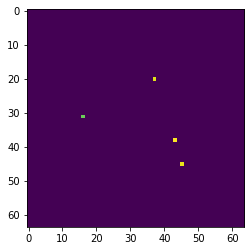

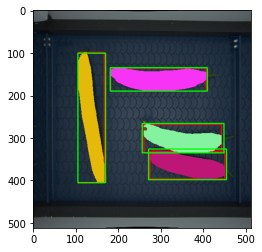

In [81]:
for i,batch in tqdm(enumerate(test_loader)):
    preds=model(batch)
    imgs=batch["img"]
    lbl=batch["center"]
    lbl_boxes=batch["bboxs"]
    boxes=preds["boxes"]
    pred_cats=preds["centers"]
    pred_msks=preds["masks"]
    bidx=0
    ## Draw Preds
    img=vis_boxes(imgs[bidx],boxes)
    img=vis_masks(img.copy(),pred_msks,boxes)
    ## Draw GT Boxes
    nz=torch.nonzero(lbl)
    for idx in range(len(nz)):
        lbl_box=lbl_boxes[nz[idx][0],nz[idx][1],nz[idx][2]].numpy()
        cv2.rectangle(img, (int(lbl_box[0]),int(lbl_box[1])), (int(lbl_box[2]),int(lbl_box[3])), (0,255,0), 2)
    plt.figure(2)
    plt.imshow(pred_cats.detach().squeeze(0).numpy())
    plt.figure(3)
    plt.imshow(img)
    break
    #cv2.imwrite(f"{res_dir}{i}_seg.png",img)
    #cv2.imwrite(f"{res_dir}{i}_cent.png",pred_cats.detach().squeeze(0).numpy())
    

In [ ]:
! tar -cvf cnet_res_v3.tar centernet/v3

In [ ]:
## Evaluation

In [90]:
import torch.utils.data as data
import torch
## For single stage not FPN
class valLoader(data.Dataset):
    
    def __init__(self, img_sz=512,grid_sz=64,seg_sz=64,data=None):
        super(valLoader, self).__init__()
        self.img_sz=img_sz
        self.grid_sz=grid_sz
        self.seg_sz=seg_sz
        self.imgs=[]
        self.label_pts=[]
        self.label_off=[]
        self.label_masks=[]
        self.label_boxes=[]
        self.getData(data)
        
    def getData(self,data):
        for i,d in tqdm(enumerate(data)):
            image=d.images.numpy()
            image=cv2.resize(image,(self.img_sz,self.img_sz))
            masks=d.masks.numpy().astype(np.uint8)*255
            img_cs=set(())
            mod_masks=[]
            mod_boxes=[]
            mod_centers=[]
            mod_offsets=[]
            grid=np.zeros((self.grid_sz,self.grid_sz),dtype=np.uint8)
            for j in range(masks.shape[-1]):
                mask=masks[...,j]
                mask=cv2.resize(mask,(self.img_sz,self.img_sz),cv2.INTER_NEAREST)
                cY,cX=find_center(mask)
                if not mask[cY][cX]:
                    cY,cX=fixed_points(cX,cY,mask)
                cY,cX,offy,offx,img_cs=get_quantized_center(cX,cY,mask,dst_size=self.grid_sz,p_sofar=img_cs)
                mod_centers.append([cY,cX])
                mod_offsets.append([offy,offx])
                nzeros=np.nonzero(mask)
                ys=nzeros[0]
                xs=nzeros[1]
                ymin=min(ys)
                ymax=max(ys)
                xmin=min(xs)
                xmax=max(xs)
                croped_mask = mask[ymin : ymax , xmin: xmax]
                ## resize masks to eventual size of masks to be predicted
                croped_mask=cv2.resize(croped_mask,(self.seg_sz,self.seg_sz),cv2.INTER_NEAREST)
                mod_masks.append(croped_mask)            
                mod_boxes.append([xmin,ymin,xmax,ymax])
                # Considering only one calss can add dict with value corresponding to class for multiclass
            self.label_pts.append(mod_centers)
            self.label_off.append(mod_offsets)
            self.imgs.append(image)
            self.label_masks.append(mod_masks)
            self.label_boxes.append(mod_boxes)
        
    def __getitem__(self, index):
        
        tgt_img = self.imgs[index]
        masks = self.label_masks[index]
        boxes = self.label_boxes[index]
        rgb=transform((torch.from_numpy(tgt_img).float()/255))
        # There is only one class for now
        labels= torch.ones((len(masks),), dtype=torch.int64)
        iscrowd = torch.zeros((len(labels),), dtype=torch.int64)
        ## convert to tensors
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        image_id = torch.tensor([index])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        target = {}
        target["boxes"] = boxes
        target["masks"] = masks//255
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        target["labels"] = labels
        
        return rgb, target
    
    def __len__(self):
        return len(ds)

In [91]:
val_dataset = valLoader(data=ds)
val_loader = torch.utils.data.DataLoader(
                    dataset=val_dataset, num_workers=1, 
                    batch_size=1, shuffle=True)

295it [00:23, 12.44it/s]


In [92]:
for batch in val_loader:
    rgb,target=batch
    print(rgb.shape)
    print(target.keys())
    for k,v in target.items():
        print(f"{k} has shape {v.shape}")
    break

torch.Size([1, 3, 512, 512])
dict_keys(['boxes', 'masks', 'image_id', 'area', 'iscrowd', 'labels'])
boxes has shape torch.Size([1, 1, 4])
masks has shape torch.Size([1, 1, 64, 64])
image_id has shape torch.Size([1, 1])
area has shape torch.Size([1, 1])
iscrowd has shape torch.Size([1, 1])
labels has shape torch.Size([1, 1])


In [93]:
#!pip install pycocotools

In [94]:
from coco_utils import get_coco_api_from_dataset, coco_to_excel

In [95]:
coco = get_coco_api_from_dataset(val_loader.dataset)

100%|██████████| 295/295 [00:00<00:00, 391.68it/s]

creating index...
index created!


In [96]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [97]:
iou_types = ["bbox"]
iou_types.append("segm")

In [98]:
from coco_eval import CocoEvaluator
import utils
import time

In [99]:
@torch.no_grad() 
def evaluate(coco, model, data_loader, device):
    n_threads = torch.get_num_threads()
    # FIXME remove this and make paste_masks_in_image run on the GPU
    torch.set_num_threads(1)
    cpu_device = torch.device("cpu")
    model.eval()
    model.to(device)
    metric_logger = utils.MetricLogger(delimiter="  ")
    header = 'Test:'

    coco_evaluator = CocoEvaluator(coco, iou_types)

    for image, targets in metric_logger.log_every(data_loader, 5, header):
        #print(image.shape)
        image = [image.to(device)]
        #print(image[0].shape)
        #targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        targets = [{k: v.to(device) for k, v in targets.items()}]

        torch.cuda.synchronize()
        model_time = time.time()
        outputs = model({"img":image[0]})

        #outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
        outputs = [{k: v.to(cpu_device) for k, v in outputs.items()}]
        model_time = time.time() - model_time

        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        evaluator_time = time.time()
        coco_evaluator.update(res)
        evaluator_time = time.time() - evaluator_time
        metric_logger.update(model_time=model_time, evaluator_time=evaluator_time)

    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    coco_evaluator.synchronize_between_processes()

    # accumulate predictions from all images
    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    torch.set_num_threads(n_threads)
    return coco_evaluator

In [100]:
coco_evaluator = evaluate(coco, model, val_loader, device)

Test:  [  0/295]  eta: 0:24:42  model_time: 4.9426 (4.9426)  evaluator_time: 0.0052 (0.0052)  time: 5.0241  data: 0.0759  max mem: 109
Test:  [  5/295]  eta: 0:19:23  model_time: 3.5736 (3.9921)  evaluator_time: 0.0023 (0.0030)  time: 4.0122  data: 0.0165  max mem: 109
Test:  [ 10/295]  eta: 0:18:26  model_time: 3.5736 (3.8675)  evaluator_time: 0.0022 (0.0027)  time: 3.8817  data: 0.0108  max mem: 109
Test:  [ 15/295]  eta: 0:18:21  model_time: 3.5639 (3.9224)  evaluator_time: 0.0022 (0.0028)  time: 3.9347  data: 0.0087  max mem: 109
Test:  [ 20/295]  eta: 0:17:48  model_time: 3.5638 (3.8727)  evaluator_time: 0.0022 (0.0027)  time: 3.8266  data: 0.0041  max mem: 109
Test:  [ 25/295]  eta: 0:17:37  model_time: 3.5639 (3.9048)  evaluator_time: 0.0022 (0.0027)  time: 3.8861  data: 0.0040  max mem: 109
Test:  [ 30/295]  eta: 0:17:16  model_time: 3.9265 (3.8996)  evaluator_time: 0.0026 (0.0027)  time: 3.9247  data: 0.0040  max mem: 109
Test:  [ 35/295]  eta: 0:17:10  model_time: 3.9516 (3.9